# Dopamine mediates the bidirectional update of interval timing

Authors

In [1]:
using Printf, FileIO
using Pipe: @pipe

In [ ]:
using HypothesisTests, CategoricalArrays

In [5]:
include("preprocess.jl")
include("plotting.jl");

## Parameters

In [2]:
dir_raw       = "C:/Users/antho/Documents/harvard/time_perception/GCaMP6f_and_tdTomato_Photometry_and_Behavior/"
dir_processed = "C:/Users/antho/Documents/harvard/time_perception/processed/"

verbose = 0
const nbins = 20;

### Process raw photometry signals

In [3]:
binmode = AbsBin()
binalign = AlignLick()

dirs = readdir(dir_raw)
dirs = filter(d -> !(d in EXCLUDED_DIRS), dirs);

In [6]:
meta_all = nothing
bins_all = nothing

for dir in dirs
    meta, bins = get_bins(dir_raw * "/" * dir, nbins;
        binmode=binmode,
        binalign=binalign,
        cachedir=dir_processed,
        verbose=0)
    
    if meta_all === nothing
        meta_all = meta
        bins_all = bins
    else
        append!(meta_all, meta)
        append!(bins_all, bins)
    end
end

### Compute empirical bidirectional plasticity function

## Get avg trial shape

In [9]:
function damatmean(da)
    m = [mean(skipmissing(da[:,i])) for i in 1:size(da,2)]
    replace!(m, NaN => 0)
    return m
end
;

### For single mouse

In [11]:
dir = "B5_signalname_15" # "B5_signalname_9" # B1_signalname_13

#fname, matfile = "b1_day13op", nothing
fname, matfile = load_matfile(dir)
exclusions = load_exclusions(dir)
;

In [12]:
trials, da_signal = get_avg_trials(fname, matfile, exclusions=exclusions, verbose=1);

Loading b5_day15_hybop0 from scratch...
No lick found for cue 253
No lick found for cue 254
No lick found for cue 255
No lick found for cue 296
No lick found for cue 339
No lick found for cue 379
No lick found for cue 424
No lick found for cue 520
No lick found for cue 576
No lick found for cue 622
No lick found for cue 625
No lick found for cue 634
No lick found for cue 644
No lick found for cue 693
No lick found for cue 718
No lick found for cue 721
No lick found for cue 737
No lick found for cue 744
No lick found for cue 746
No lick found for cue 748
No lick found for cue 752
No lick found for cue 753
No lick found for cue 756
No lick found for cue 758
No lick found for cue 759
No lick found for cue 760
No lick found for cue 761
No lick found for cue 762
No lick found for cue 763
No lick found for cue 765
No lick found for cue 766
No lick found for cue 767
No lick found for cue 769
No lick found for cue 772
No lick found for cue 773
No lick found for cue 774
No lick found for cue 77

In [13]:
trials_cue  = falses(length(da_signal))
trials_lick = falses(length(da_signal))

for trialidx in 1:length(da_signal)
    licktime = trials.lick[trialidx] - trials.cue[trialidx]
    if licktime < 7
        i1 = round(Int, 1000*licktime) # we already start 500ms in advance
        i2 = i1 + 999

        meanda   = mean(da_signal[trialidx])
        meancue  = mean(da_signal[trialidx][1:1000])
        meanlick = mean(da_signal[trialidx][i1:i2])

        if meancue > meanlick && meancue > meanda
            # DA at cue is high
            trials_cue[trialidx] = true
        elseif meanlick > meancue && meanlick > meanda
            # DA at lick is high
            trials_lick[trialidx] = true
        else
            # no particularly high DA, do nothing
        end
    end
end

trials_cue_after = falses(nrow(trials))
trials_cue_after[min.(findall(trials_cue) .+ 1, nrow(trials))] .= true

trials_lick_after = falses(nrow(trials))
trials_lick_after[min.(findall(trials_lick) .+ 1, nrow(trials))] .= true
;

In [14]:
maxsignallen = maximum(length(s) for s in da_signal) - 1000
da_mat = zeros(Union{Missing, Float64}, length(da_signal), maxsignallen)

for i in 1:length(da_signal)
    da_mat[i,1:(length(da_signal[i])-1000)] .= da_signal[i][501:end-500]
end

replace!(da_mat, 0.0 => missing);

In [ ]:
smooth(y, :gaussian, 101, 0.1)

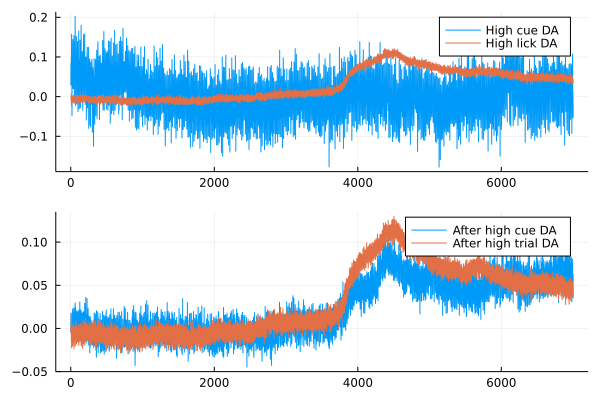

In [15]:
lickbin = [3.6, 4.3]
lickbintrials = lickbin[1] .< trials.lick .- trials.cue .< lickbin[2]

# current trial
p1 = plot(damatmean(da_mat[lickbintrials .& trials_cue,:]), label="High cue DA")
plot!(damatmean(da_mat[lickbintrials .& trials_lick,:]), label="High lick DA")

# after
p2 = plot(damatmean(da_mat[lickbintrials .& trials_cue_after,:]), label="After high cue DA")
plot!(damatmean(da_mat[lickbintrials .& trials_lick_after,:]), label="After high lick DA")

layout = @layout([
    a 
    b    
])
plot(p1,p2,
    layout=layout)

### Again but for all mice

In [10]:
dirs = readdir(dir_data)
nload = length(dirs)

exclusion_sessions = [
    "H14_signalname_5",
    "H14_signalname_7",
    "H14_signalname_8",
    "H14_signalname_10",
    "H14_signalname_12",
    "H14_signalname_14",
    "H14_signalname_16",
    "H14_signalname_18",
    
    "H15_signalname_5",
    "H15_signalname_7",
    "H15_signalname_8",
    "H15_signalname_10_1",
    "H15_signalname_10_2",
    "H15_signalname_12_1",
    "H15_signalname_12_2",
    "H15_signalname_16",
    "H15_signalname_18",
];

In [11]:
padding = 0.5
padding_ms = round(Int, padding * 1000);

In [12]:
da_trials_all = Vector{DataFrame}(undef, nload)
da_signal_all = Vector{Vector{Vector{Float64}}}(undef, nload)

for i in 1:nload
    if dirs[i] in exclusion_sessions
        println("Skipping session $(dirs[i])")
    else
        fname, matfile = load_matfile(dirs[i])
        exclusions = load_exclusions(dirs[i])
        
        trials, da_signal = get_avg_trials(fname, matfile, exclusions=exclusions, padding=padding, verbose=1)
        
        da_trials_all[i] = trials
        da_signal_all[i] = da_signal
    end    
end

function isundef(arr, index)
    try
        arr[index]
        return false
    catch e
        return true
    end
end

da_trials_all = da_trials_all[filter(i -> !isundef(da_trials_all, i), 1:nload)]
da_trials_all  = reduce(vcat, da_trials_all)

da_signal_all = da_signal_all[filter(i -> !isundef(da_signal_all, i), 1:nload)]
da_signal_all = reduce(vcat, da_signal_all)
;

Loading b1_day13op from scratch...
No lick found for cue 135
No lick found for cue 136
No lick found for cue 140
No lick found for cue 141
No lick found for cue 142
No lick found for cue 153
No lick found for cue 176
Processing 151 trials...

Loading b1_day15hybop from scratch...
No lick found for cue 183
Processing 124 trials...

Loading b1_day18_0ms_hybop from scratch...
No lick found for cue 94
No lick found for cue 228
No lick found for cue 230
No lick found for cue 252
No lick found for cue 253
No lick found for cue 255
No lick found for cue 262
No lick found for cue 264
No lick found for cue 268
No lick found for cue 277
No lick found for cue 279
No lick found for cue 281
No lick found for cue 284
No lick found for cue 312
No lick found for cue 316
Processing 298 trials...

Loading b1_day19_0ms_allop from scratch...
No lick found for cue 381
No lick found for cue 401
No lick found for cue 512
No lick found for cue 528
No lick found for cue 585
Processing 528 trials...

Loading b1

No lick found for cue 858
No lick found for cue 859
No lick found for cue 879
No lick found for cue 880
No lick found for cue 914
No lick found for cue 915
No lick found for cue 916
No lick found for cue 917
Processing 709 trials...

Loading b2_day21_0ms_allop from scratch...
No lick found for cue 33
No lick found for cue 237
No lick found for cue 239
No lick found for cue 275
No lick found for cue 316
No lick found for cue 318
No lick found for cue 319
No lick found for cue 335
No lick found for cue 339
No lick found for cue 347
No lick found for cue 350
No lick found for cue 355
No lick found for cue 356
No lick found for cue 357
No lick found for cue 361
No lick found for cue 363
No lick found for cue 368
No lick found for cue 369
No lick found for cue 370
No lick found for cue 371
No lick found for cue 377
No lick found for cue 381
No lick found for cue 382
No lick found for cue 384
No lick found for cue 387
No lick found for cue 388
No lick found for cue 390
No lick found for cue 

No lick found for cue 642
No lick found for cue 643
No lick found for cue 644
No lick found for cue 646
No lick found for cue 648
No lick found for cue 649
No lick found for cue 667
No lick found for cue 670
No lick found for cue 671
No lick found for cue 673
No lick found for cue 676
No lick found for cue 677
No lick found for cue 679
No lick found for cue 680
No lick found for cue 682
No lick found for cue 687
No lick found for cue 688
No lick found for cue 689
No lick found for cue 692
No lick found for cue 694
No lick found for cue 695
No lick found for cue 697
No lick found for cue 698
No lick found for cue 699
No lick found for cue 701
No lick found for cue 702
No lick found for cue 704
No lick found for cue 705
No lick found for cue 706
No lick found for cue 707
No lick found for cue 710
No lick found for cue 711
No lick found for cue 712
Processing 534 trials...

Loading b3_day7 from scratch...


┌ Warning: More lamp_offs than cues for mouse b3_day7, trimming
└ @ Main In[7]:19


Processing 98 trials...


┌ Warning: More lamp_ons than cues for mouse b3_day7, trimming
└ @ Main In[7]:23



Loading b5_day12_hybop0 from scratch...
No SNc measurements found for mouse b5_day12_hybop0, using VTA
No lick found for cue 172
No lick found for cue 353
No lick found for cue 384
No lick found for cue 391
No lick found for cue 393
No lick found for cue 394
No lick found for cue 395
No lick found for cue 398
No lick found for cue 399
No lick found for cue 401
No lick found for cue 402
No lick found for cue 403
No lick found for cue 409
No lick found for cue 410
No lick found for cue 411
No lick found for cue 413
No lick found for cue 420
No lick found for cue 424
No lick found for cue 426
No lick found for cue 441
No lick found for cue 488
No lick found for cue 530
No lick found for cue 546
No lick found for cue 547
No lick found for cue 554
No lick found for cue 558
No lick found for cue 561
No lick found for cue 563
No lick found for cue 564
No lick found for cue 566
No lick found for cue 569
No lick found for cue 584
Processing 549 trials...

Loading b5_day13_hybop0 from scratch..

┌ Warning: More lamp_ons than cues for mouse b5_day16_allop0_file1, trimming
└ @ Main In[7]:23



No lick found for cue 86
Processing 508 trials...

Loading b5_day16_allop0_file2 from scratch...
No SNc measurements found for mouse b5_day16_allop0_file2, using VTA


┌ Warning: More lamp_offs than cues for mouse b5_day16_allop0_file2, trimming
└ @ Main In[7]:19
┌ Warning: More lamp_ons than cues for mouse b5_day16_allop0_file2, trimming
└ @ Main In[7]:23


No lick found for cue 13
No lick found for cue 37
No lick found for cue 137
No lick found for cue 139
No lick found for cue 141
No lick found for cue 145
No lick found for cue 164
No lick found for cue 174
No lick found for cue 187
No lick found for cue 192
No lick found for cue 263
No lick found for cue 277
No lick found for cue 281
No lick found for cue 309
No lick found for cue 311
No lick found for cue 313
No lick found for cue 316
No lick found for cue 317
No lick found for cue 320
No lick found for cue 324
No lick found for cue 326
No lick found for cue 327
No lick found for cue 328
No lick found for cue 343
No lick found for cue 345
No lick found for cue 348
No lick found for cue 350
No lick found for cue 351
No lick found for cue 354
No lick found for cue 356
No lick found for cue 358
No lick found for cue 361
No lick found for cue 362
No lick found for cue 363
No lick found for cue 366
No lick found for cue 368
No lick found for cue 369
No lick found for cue 371
No lick found 

┌ Warning: Found dash without 2 numbers around it, ignoring
└ @ Main C:\Users\antho\Google Drive\Harvard\Thesis\Time perception\notebooks\load_data.jl:206



No lick found for cue 52
No lick found for cue 76
No lick found for cue 85
No lick found for cue 90
No lick found for cue 129
No lick found for cue 130
No lick found for cue 155
No lick found for cue 159
No lick found for cue 160
No lick found for cue 163
No lick found for cue 165
No lick found for cue 168
No lick found for cue 170
No lick found for cue 171
No lick found for cue 172
No lick found for cue 180
No lick found for cue 181
No lick found for cue 182
No lick found for cue 185
No lick found for cue 186
No lick found for cue 188
No lick found for cue 189
No lick found for cue 191
No lick found for cue 192
No lick found for cue 193
Processing 161 trials...

Loading b5_day8_allop0 from scratch...
No SNc measurements found for mouse b5_day8_allop0, using VTA
No lick found for cue 92
No lick found for cue 95
No lick found for cue 185
No lick found for cue 217
No lick found for cue 258
No lick found for cue 343
No lick found for cue 344
No lick found for cue 345
No lick found for cu

┌ Warning: Found dash without 2 numbers around it, ignoring
└ @ Main C:\Users\antho\Google Drive\Harvard\Thesis\Time perception\notebooks\load_data.jl:206


No lick found for cue 232
No lick found for cue 490
No lick found for cue 491
No lick found for cue 492
No lick found for cue 680
No lick found for cue 1119
No lick found for cue 1324
Processing 1292 trials...

Loading b6_day12_allop0 from scratch...
Processing 1291 trials...

Loading b6_day13_allop0 from scratch...


┌ Warning: More lamp_offs than cues for mouse b6_day13_allop0, trimming
└ @ Main In[7]:19
┌ Warning: More lamp_ons than cues for mouse b6_day13_allop0, trimming
└ @ Main In[7]:23


No lick found for cue 512
No lick found for cue 513
No lick found for cue 517
No lick found for cue 521
No lick found for cue 524
No lick found for cue 525
No lick found for cue 527
No lick found for cue 528
No lick found for cue 529
No lick found for cue 530
No lick found for cue 532
No lick found for cue 533
No lick found for cue 534
No lick found for cue 539
No lick found for cue 540
No lick found for cue 548
No lick found for cue 549
No lick found for cue 551
No lick found for cue 552
No lick found for cue 553
No lick found for cue 554
No lick found for cue 557
No lick found for cue 561
No lick found for cue 562
No lick found for cue 565
No lick found for cue 566
No lick found for cue 567
No lick found for cue 568
No lick found for cue 574
No lick found for cue 576
No lick found for cue 578
No lick found for cue 581
No lick found for cue 582
No lick found for cue 584
No lick found for cue 586
No lick found for cue 588
No lick found for cue 592
No lick found for cue 593
No lick foun

┌ Warning: More lamp_offs than cues for mouse b6_day14_hybop0_file2, trimming
└ @ Main In[7]:19
┌ Warning: More lamp_ons than cues for mouse b6_day14_hybop0_file2, trimming
└ @ Main In[7]:23


No lick found for cue 47
No lick found for cue 48
No lick found for cue 49
No lick found for cue 50
No lick found for cue 51
No lick found for cue 53
No lick found for cue 54
No lick found for cue 56
No lick found for cue 57
No lick found for cue 58
No lick found for cue 59
No lick found for cue 61
No lick found for cue 62
No lick found for cue 63
No lick found for cue 64
No lick found for cue 66
No lick found for cue 67
No lick found for cue 68
No lick found for cue 69
No lick found for cue 70
No lick found for cue 71
No lick found for cue 73
No lick found for cue 74
No lick found for cue 76
No lick found for cue 77
No lick found for cue 78
No lick found for cue 79
No lick found for cue 80
No lick found for cue 82
No lick found for cue 83
No lick found for cue 84
No lick found for cue 85
No lick found for cue 86
No lick found for cue 87
No lick found for cue 88
No lick found for cue 89
No lick found for cue 91
No lick found for cue 92
No lick found for cue 94
No lick found for cue 95



Loading h4_day22_allop_0ms from scratch...
No lick found for cue 400
No lick found for cue 434
No lick found for cue 435
No lick found for cue 470
No lick found for cue 489
No lick found for cue 532
No lick found for cue 542
No lick found for cue 579
No lick found for cue 585
No lick found for cue 588
No lick found for cue 592
No lick found for cue 594
No lick found for cue 609
No lick found for cue 612
No lick found for cue 614
No lick found for cue 616
Processing 570 trials...

Loading h4_day23_0msallop from scratch...
No lick found for cue 477
No lick found for cue 529
Juice delivered, but lick was wrong for trial 558
No lick found for cue 628
Processing 622 trials...

Loading h4_day24_0msallop from scratch...
Processing 283 trials...

Loading h4_day25_0msallop from scratch...
No lick found for cue 298
No lick found for cue 453
No lick found for cue 471
No lick found for cue 474
No lick found for cue 478
No lick found for cue 479
No lick found for cue 544
No lick found for cue 554


┌ Warning: No exclusion file found
└ @ Main C:\Users\antho\Google Drive\Harvard\Thesis\Time perception\notebooks\load_data.jl:162



No lick found for cue 394
No lick found for cue 395
No lick found for cue 771
No lick found for cue 782
No lick found for cue 794
No lick found for cue 797
No lick found for cue 799
No lick found for cue 801
No lick found for cue 813
No lick found for cue 814
No lick found for cue 815
No lick found for cue 817
No lick found for cue 819
No lick found for cue 844
No lick found for cue 860
No lick found for cue 863
No lick found for cue 876
No lick found for cue 885
No lick found for cue 890
Processing 871 trials...



In [13]:
trials_cue  = falses(length(da_signal_all))
trials_lick = falses(length(da_signal_all))

trials_cue_after  = falses(length(da_signal_all))
trials_lick_after = falses(length(da_signal_all))

for trialidx in 1:length(da_signal_all)
    licktime = da_trials_all.lick[trialidx] - da_trials_all.cue[trialidx]
    licktime_ms = round(Int, licktime * 1000)
    if licktime < 7 && licktime > 0 && length(da_signal_all[trialidx]) > 2000
        meanda   = mean(da_signal_all[trialidx])
        meancue  = mean(da_signal_all[trialidx][1+padding_ms:1+padding_ms+licktime_ms])
        meanlick = mean(da_signal_all[trialidx][1+padding_ms+licktime_ms:end])
        #lickend  = min(500+padding_ms+licktime_ms, length(da_signal_all[trialidx]))
        #meanlick = mean(da_signal_all[trialidx][1+padding_ms+licktime_ms:lickend])

        if meancue > meanlick && meancue > meanda
            # DA at cue is high
            trials_cue[trialidx] = true
            if trialidx < length(da_signal_all) && da_trials_all.session[trialidx+1] == da_trials_all.session[trialidx] && da_trials_all.trial[trialidx+1] == da_trials_all.trial[trialidx]+1
                licktime_next = da_trials_all.lick[trialidx+1] - da_trials_all.cue[trialidx+1]
                trials_cue_after[trialidx+1] = licktime_next < 7 && licktime_next > 0
            end
        elseif meanlick > meancue && meanlick > meanda
            # DA at lick is high
            trials_lick[trialidx] = true
            if trialidx < length(da_signal_all) && da_trials_all.session[trialidx+1] == da_trials_all.session[trialidx] && da_trials_all.trial[trialidx+1] == da_trials_all.trial[trialidx]+1
                licktime_next = da_trials_all.lick[trialidx+1] - da_trials_all.cue[trialidx+1]
                trials_lick_after[trialidx+1] = licktime_next < 7 && licktime_next > 0
            end
        else
            # no particularly high DA, do nothing
        end
    end
end
;

In [14]:
idxs = trials_cue .| trials_cue_after .| trials_lick .| trials_lick_after

maxlen = maximum(length(s) for s in da_signal_all[idxs])
da_mat_cue  = zeros(Union{Missing, Float64}, length(da_signal_all), maxlen)
da_mat_lick = zeros(Union{Missing, Float64}, length(da_signal_all), maxlen)

smoothing(y) = smooth(y, :hamming, 100)

for i in 1:length(da_signal_all)
    if idxs[i]
        licktime = da_trials_all.lick[i] - da_trials_all.cue[i]
        da_mat_cue[i,1:length(da_signal_all[i])] .= da_signal_all[i] |> smoothing
        
        i_lick_beg = padding_ms + round(Int, licktime*1000)
        i_lick_end = min(i_lick_beg + padding_ms, length(da_signal_all[i]))
        da_mat_lick[i,end-i_lick_end+1:end] .= da_signal_all[i][1:i_lick_end] |> smoothing
    end
end

replace!(da_mat_cue, 0.0 => missing)
replace!(da_mat_lick, 0.0 => missing)
;

In [178]:
#da_mat_cue .-= da_trials_all.da_baseline;
#da_mat_lick .-= da_trials_all.da_baseline; 

#### Align by cue

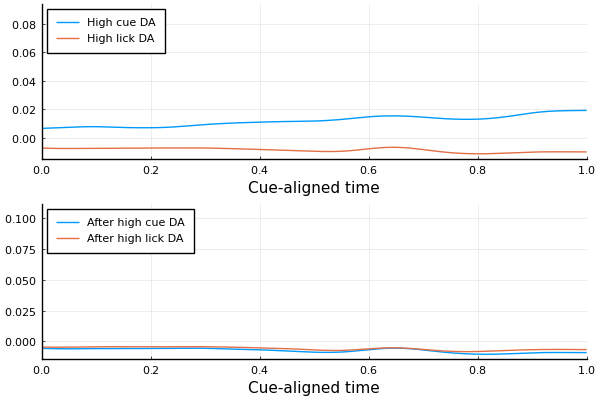

In [183]:
lickbin = [3.3, 7]
lickbintrials = lickbin[1] .< da_trials_all.lick .- da_trials_all.cue .< lickbin[2]

x = LinRange(0, size(da_mat_cue,2) / 1000.0, size(da_mat_cue,2))
smooth_plot(y) = y #smooth(y, :hamming, 10)

# current trial
p1 = plot(x, damatmean(da_mat_cue[lickbintrials .& trials_cue,:]), label="High cue DA")
plot!(x, damatmean(da_mat_cue[lickbintrials .& trials_lick,:]), label="High lick DA")

# after
p2 = plot(x, damatmean(da_mat_cue[lickbintrials .& trials_cue_after,:]) |> smooth_plot, label="After high cue DA")
plot!(x, damatmean(da_mat_cue[lickbintrials .& trials_lick_after,:]) |> smooth_plot, label="After high lick DA")

layout = @layout([
    a 
    b    
])
plot(p1,p2,
    legend=:topleft,
    xlim=(0, 1), #(lickbin[2] - 2) * 1000, lickbin[2] * 1000),
    xlabel="Cue-aligned time",
    layout=layout)

In [180]:
pyplot()

Plots.PyPlotBackend()

#### Align by lick

In [15]:
gr()

Plots.GRBackend()

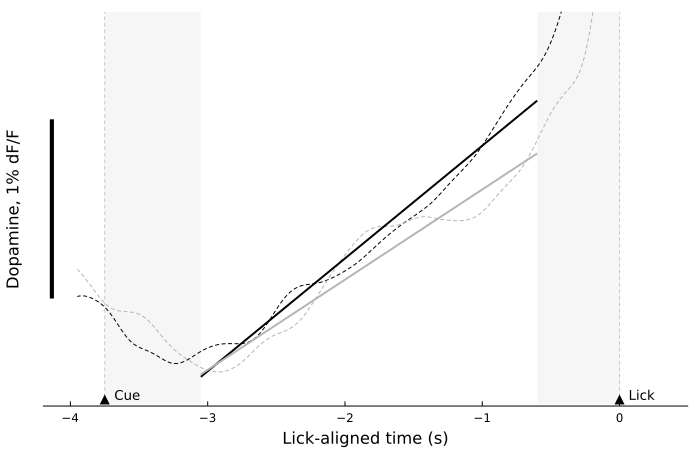

In [134]:
lickbin = [3.5, 4]
lickbintrials = lickbin[1] .< da_trials_all.lick .- da_trials_all.cue .< lickbin[2]

x = LinRange(-size(da_mat_lick,2) / 1000.0 + 0.5, 0.5, size(da_mat_lick,2))
smooth_plot(y) = smooth(y, :rect, 201)

xlim=(-lickbin[2] - 0.2, 0.5)
ylim=(-1.1, 1.1)

annotation_margin_x = 0.075
annotation_margin_y = (ylim[2] - ylim[1]) / 60


# current trial
#p1 = plot(x, damatmean(da_mat_lick[lickbintrials .& trials_cue,:]) |> smooth_plot, label="High cue DA",
#    linewidth=2,)
#plot!(x, damatmean(da_mat_lick[lickbintrials .& trials_lick,:]) |> smooth_plot, label="High lick DA",
#    linewidth=2,)

# after
ycue  = 100 * damatmean(da_mat_lick[lickbintrials .& trials_cue_after,:])
ylick = 100 * damatmean(da_mat_lick[lickbintrials .& trials_lick_after,:])

xlen = round(Int, mean(lickbin)*1000 - 1300)

xcue = ones(xlen,2)
xcue[:,2] = collect(LinRange(-mean(lickbin)+0.7, -0.6, xlen))

xlick = ones(xlen,2)
xlick[:,2] = collect(LinRange(-mean(lickbin)+0.7, -0.6, xlen))

olscue  = fit(LinearModel, xcue,   ycue[end-padding_ms-round(Int,mean(lickbin)*1000)+700+1:end-padding_ms-600])
olslick = fit(LinearModel, xlick, ylick[end-padding_ms-round(Int,mean(lickbin)*1000)+700+1:end-padding_ms-600])

c1 = colorant"#00b894"
c2 = colorant"#e17055"

c1 = :black      # colorant"#00b894"
c2 = colorant"#b5b5b5" # colorant"#e17055"

# buffer rectangles
crect = colorant"#f6f6f6"

pslope = plot(rectangle(-buffer_post_cue,4,-mean(lickbin)+buffer_post_cue,-1.09),
    color=crect,
    linecolor=nothing,
    label="")

plot!(rectangle(buffer_pre_lick,4,-buffer_pre_lick,-1.09),
    color=crect,
    linecolor=nothing,
    label="")

# thin DA signal
plot!(x, ycue |> smooth_plot,
    color=c1,
    linewidth=1,
    linestyle=:dash,
    label="", #"After high cue DA"
)
plot!(x, ylick |> smooth_plot,
    color=c2,
    linewidth=1,
    linestyle=:dash,
    label="" # "After high lick DA",
)

# slope
plot!(xcue[:,2], predict(olscue, xcue),
    label="High DA after cue",#string(round(coef(olscue)[2], digits=5)),
    color=c1,
    linewidth=2,
    linestyle=:solid,)
plot!(xlick[:,2], predict(olslick, xlick),
    label="High DA after lick",#string(round(coef(olslick)[2], digits=5)),
    color=c2,
    linewidth=2,
    linestyle=:solid,)

# Annotations
# Cue annotation
vline!([-mean(lickbin)],
    color=:black,
    opacity=0.2,
    linestyle=:dash,
    label="",
)
scatter!([-mean(lickbin)], [ylim[1] + annotation_margin_y],
    markershape = :utriangle,
    markersize = 5,
    markeralpha = 1,
    markercolor = :black,
    markerstrokewidth = 1,
    markerstrokealpha = 1,
    markerstrokecolor = :black,
    label="")
annotate!(-mean(lickbin) + annotation_margin_x, ylim[1] + annotation_margin_y + 0.025,
    text("Cue", :black, :left, 9))

# Lick annotation
vline!([0],
    color=:black,
    opacity=0.2,
    linestyle=:dash,
    label="",
)
scatter!([0], [ylim[1] + annotation_margin_y],
    markershape = :utriangle,
    markersize = 5,
    markeralpha = 1,
    markercolor = :black,
    markerstrokewidth = 1,
    markerstrokealpha = 1,
    markerstrokecolor = :black,
    label="")
annotate!(-0 + annotation_margin_x, ylim[1] + annotation_margin_y + 0.025,
    text("Lick", :black, :left, 9))

# Scale annotation
plot!(rectangle(0.4, ylim[2]-ylim[1], -mean(lickbin) - 0.6, ylim[1]+0.1),
    color=:white,
    linecolor=nothing,
    label="")

plot!(rectangle(0.03, 1, -mean(lickbin) - 0.4, mean(ylim)-0.5),
    color=:black,
    linecolor=nothing,
    label="")

plot!(
    legend=nothing,
    grid=:off,
    size=(700, 450),
    xlim=xlim,
    ylim=ylim,
    xlabel="Lick-aligned time (s)",
    ylabel="Dopamine, 1% dF/F",
    yaxis=false,
    yticks=nothing,
    #guidefont=font(guidefontsize, fontfamily),
    #tickfont=font(tickfontsize, fontfamily),
    left_margin=5Plots.mm,
)

In [43]:
savefig("figs/fig_empirical_da.pdf")

#### Statistical significance of slope diff

In [34]:
slopes_cue = da_trials_all.da_slope[lickbintrials .& trials_cue_after,:]
slopes_lick = da_trials_all.da_slope[lickbintrials .& trials_lick_after,:]
;

In [54]:
EqualVarianceTTest(
    vec(slopes_cue),
    vec(slopes_lick),
)

Two sample t-test (equal variance)
----------------------------------
Population details:
    parameter of interest:   Mean difference
    value under h_0:         0
    point estimate:          0.00205068
    95% confidence interval: (0.0001, 0.004)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.0362

Details:
    number of observations:   [757,572]
    t-statistic:              2.096725217383953
    degrees of freedom:       1327
    empirical standard error: 0.0009780404416470264


In [119]:
length(slopes_cue)

757

In [120]:
length(slopes_lick)

572

## Center around first lick time, consider effect on next trial

In [10]:
dir = "B5_signalname_15" # "B1_signalname_13" # "B5_signalname_9" # B1_signalname_13

#fname, matfile = "b1_day13op", nothing
fname, matfile = load_matfile(dir)
exclusions = load_exclusions(dir)
;

In [11]:
trials, da_bins = load_trials(fname, matfile, exclusions=exclusions, use_cache=false, save_cache=false, verbose=1);

Loading b5_day15_hybop0 from scratch...
No lick found for cue 253
No lick found for cue 254
No lick found for cue 255
No lick found for cue 296
No lick found for cue 339
No lick found for cue 379
No lick found for cue 424
No lick found for cue 520
No lick found for cue 576
No lick found for cue 622
No lick found for cue 625
No lick found for cue 634
No lick found for cue 644
No lick found for cue 693
No lick found for cue 718
No lick found for cue 721
No lick found for cue 737
No lick found for cue 744
No lick found for cue 746
No lick found for cue 748
No lick found for cue 752
No lick found for cue 753
No lick found for cue 756
No lick found for cue 758
No lick found for cue 759
No lick found for cue 760
No lick found for cue 761
No lick found for cue 762
No lick found for cue 763
No lick found for cue 765
No lick found for cue 766
No lick found for cue 767
No lick found for cue 769
No lick found for cue 772
No lick found for cue 773
No lick found for cue 774
No lick found for cue 77

In [12]:
# snc = jdict(matfile["$(fname)_SNc"])
# y = snc["values"]
# 
# ysmooth = mapwindow(median, y, 5)
# ysmooth = filtfilt(digitalfilter(Lowpass(10, fs=fs), Butterworth(2)), ysmooth)
# 
# ysmooth_highpass = filtfilt(digitalfilter(Highpass(0.001, fs=fs), Butterworth(2)), ysmooth)
# ysmooth_lowpass  = filtfilt(digitalfilter( Lowpass(0.001, fs=fs), Butterworth(2)), ysmooth)
# 
# df_f = yhat_highpass; # ./ yhat_lowpass;

In [19]:
indexes = Dict("all" => collect(1:nrow(trials)-1))

indexes["valid"]          = findall(trials.trial[2:end] .- trials.trial[1:end-1] .== 1)
indexes["rewarded"]       = findall(trials.is_rewarded[1:end-1])
indexes["valid_rewarded"] = indexes["valid"][findall(trials.is_rewarded[indexes["valid"]])] 

Δda_slopes = trials.da_slope[2:end] .- trials.da_slope[1:end-1]

licks = @. 1.0 / (trials.lick - buffer_pre_lick - (trials.cue + buffer_post_cue))
Δlicks = licks[2:end] .- licks[1:end-1]

a_da   = Dict(key => Δda_slopes[index] for (key, index) in indexes)
a_lick = Dict(key => Δlicks[index]     for (key, index) in indexes)
;

In [20]:
remove_baseline = false

da = da_bins
if remove_baseline
    da .-= trials.da_baseline
end

correlation_da   = get_correlations(da, a_da, indexes)
correlation_lick = get_correlations(da, a_lick, indexes)

b_da   = get_contributions(da, a_da, indexes)
b_lick = get_contributions(da, a_lick, indexes)
;

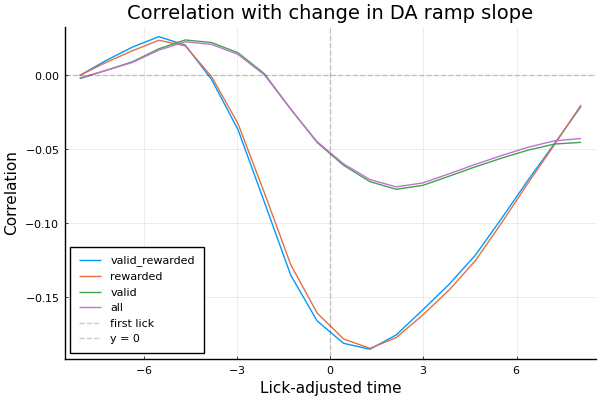

In [21]:
plot_dict(correlation_da,
    win=5,
    title="Correlation with change in DA ramp slope",
    ylabel="Correlation"
)

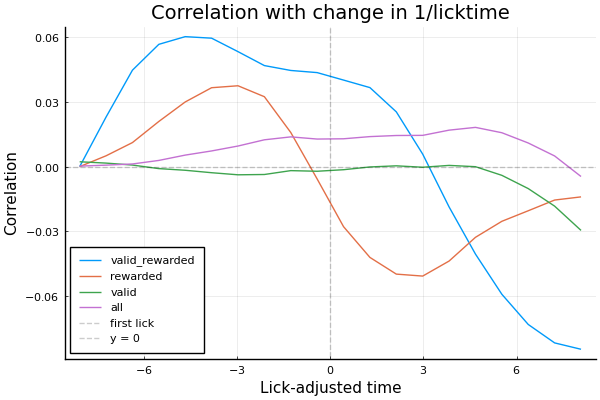

In [22]:
plot_dict(correlation_lick,
    win=5,
    title="Correlation with change in 1/licktime",
    ylabel="Correlation"
)

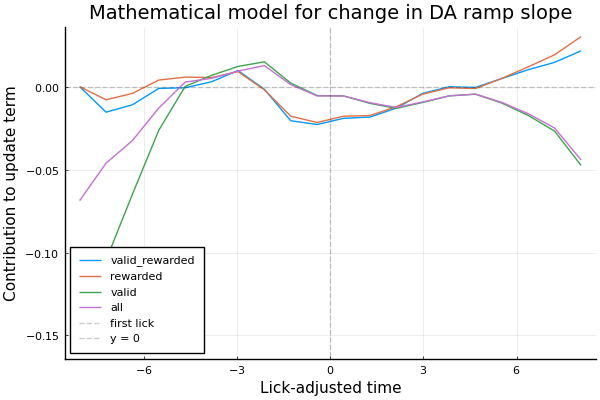

In [23]:
plot_dict(b_da,
    win=5,
    title="Mathematical model for change in DA ramp slope",
    ylabel="Contribution to update term"
)

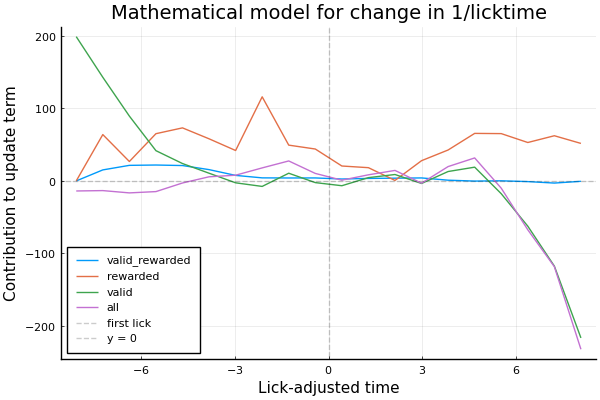

In [24]:
plot_dict(b_lick,
    win=5,
    title="Mathematical model for change in 1/licktime",
    ylabel="Contribution to update term"
)

## All mice

In [10]:
vta = [
    "b5_day12_hybop0",
    "b5_day16_allop0_file1",
    "b5_day16_allop0_file2",
    "b5_day18_allop0",
    "b6_day8_hybop0", 
    "h6_day12_hypop0",
    "h6_day9_hybop0"
];

In [11]:
dirs = [
    "B5_signalname_9",
    "B5_signalname_13",
    "B6_signalname_7",
    "B6_signalname_9",
    "H6_signalname_12",
    "H6_signalname_d14",
    "H6_signalname_d15",
]
nload = length(dirs)
;

In [12]:
dirs = readdir(dir_data)
nload = length(dirs)

exclusion_sessions = [
    "H14_signalname_5",
    "H14_signalname_7",
    "H14_signalname_8",
    "H14_signalname_10",
    "H14_signalname_12",
    "H14_signalname_14",
    "H14_signalname_16",
    "H14_signalname_18",
    
    "H15_signalname_5",
    "H15_signalname_7",
    "H15_signalname_8",
    "H15_signalname_10_1",
    "H15_signalname_10_2",
    "H15_signalname_12_1",
    "H15_signalname_12_2",
    "H15_signalname_16",
    "H15_signalname_18",
];

In [13]:
trials_all  = Vector{DataFrame}(undef, nload)
da_bins_all = Vector{DataFrame}(undef, nload)

cached_files = readdir(dir_trials)
binmode = AbsBin()
binalign = AlignLick()

use_cache = true
save_cache = true

for i in 1:nload
    if dirs[i] in exclusion_sessions
        println("Skipping session $(dirs[i])")
    else
        fname, matfile = fnames[i], nothing
    
        try        
            fname_save_trials = build_fname_trials(fname, binmode, binalign)
            fname_save_da_bins = build_fname_da_bins(fname, binmode, binalign)
            exclusions = load_exclusions(dirs[i])

            if !use_cache || !(fname_save_trials in cached_files) || !(fname_save_da_bins in cached_files)
                _, matfile = load_matfile(dirs[i])
            end

            trials, da_bins = load_trials(fname, matfile, exclusions=exclusions,
                binmode=binmode, binalign=binalign, 
                use_cache=use_cache, save_cache=save_cache)

            trials_all[i] = trials
            da_bins_all[i] = da_bins
        catch e
            println("Exception caught for mouse $fname at index $i")
            println(e)
        end
    end    
end

function isundef(arr, index)
    try
        arr[index]
        return false
    catch e
        return true
    end
end

trials_all  = trials_all[ filter(i -> !isundef(trials_all, i),  1:length(trials_all))]
da_bins_all = da_bins_all[filter(i -> !isundef(da_bins_all, i), 1:length(da_bins_all))]

trials_all  = reduce(vcat, trials_all)
da_bins_all = reduce(vcat, da_bins_all)
;

Loading b1_day13op from cache..
Loading b1_day15hybop from cache..
Loading b1_day18_0ms_hybop from cache..
Loading b1_day19_0ms_allop from cache..
Loading b1_day20_0ms_allop from cache..
Loading b2_day11_op from cache..
Loading b2_day13_hybop1 from cache..
Loading b2_day13_op2 from cache..
Loading b2_day15_op from cache..
Loading b2_day17_hybop from cache..
Loading b2_day18_hybop from cache..
Loading b2_day19_0ms_allop from cache..
Loading b2_day20_0ms_allop from cache..
Loading b2_day21_0ms_allop from cache..
Loading b2_day9_op from cache..
Loading b3_day10_op from cache..
Loading b3_day12_op from cache..
Loading b3_day14_hybop from cache..
Loading b3_day15_hybop from cache..
Loading b3_day16_hybop from cache..
Loading b3_day17_0ms_hybop from cache..
Loading b3_day18_0ms_allop from cache..
Loading b3_day19_allop_0ms from cache..
Loading b3_day20_allop_0ms from cache..
Loading b3_day21_allop_0ms from cache..
Loading b3_day7 from cache..
Loading b5_day12_hybop0 from cache..
Loading b5_d

┌ Warning: Found dash without 2 numbers around it, ignoring
└ @ Main C:\Users\antho\Google Drive\Harvard\Thesis\Time perception\notebooks\load_data.jl:206


Loading b6_day10_allop0 from cache..
Loading b6_day11_allop0 from cache..

┌ Warning: Found dash without 2 numbers around it, ignoring
└ @ Main C:\Users\antho\Google Drive\Harvard\Thesis\Time perception\notebooks\load_data.jl:206



Loading b6_day12_allop0 from cache..
Loading b6_day13_allop0 from cache..
Loading b6_day14_hybop0_file1 from cache..
Loading b6_day14_hybop0_file2 from cache..
Loading b6_day15_hybop0_file1 from cache..
Loading b6_day15_hybop0_file2 from cache..
Loading b6_day7_hybop0 from cache..
Loading b6_day8_hybop0 from cache..
Loading b6_day9_allop0 from cache..
Skipping session H14_signalname_10
Skipping session H14_signalname_12
Skipping session H14_signalname_14
Skipping session H14_signalname_16
Skipping session H14_signalname_18
Skipping session H14_signalname_5
Skipping session H14_signalname_7
Skipping session H14_signalname_8
Skipping session H15_signalname_10_1
Skipping session H15_signalname_10_2
Skipping session H15_signalname_12_1
Skipping session H15_signalname_12_2
Skipping session H15_signalname_16
Skipping session H15_signalname_18
Skipping session H15_signalname_5
Skipping session H15_signalname_7
Skipping session H15_signalname_8
Loading h3_day13op from cache..
Loading h3_day15

┌ Warning: No exclusion file found
└ @ Main C:\Users\antho\Google Drive\Harvard\Thesis\Time perception\notebooks\load_data.jl:162


Sessions with more `lamp_off`s or `lamp_on`s than cues:
- b3_day7
- b5_day16_allop0_file1
- b5_day16_allop0_file2
- b6_day13_allop0
- b6_day14_hybop0_file2

All manually checked, we can simply remove the extra events at the end of the session.

Ignore sessions with mice H14 and H15.

### Higher baseline DA is correlated with earlier first licking time in same trial

In [14]:
sessions = unique(trials_all.session);

In [15]:
baseline_corr = zeros(length(sessions))
for (i, session) in enumerate(sessions)
    ts = trials_all[findall(trials_all.session .== session),:]
    baseline_corr[i] = cor(ts.da_baseline, 1.0 ./ (ts.lick .- ts.cue))
end
;

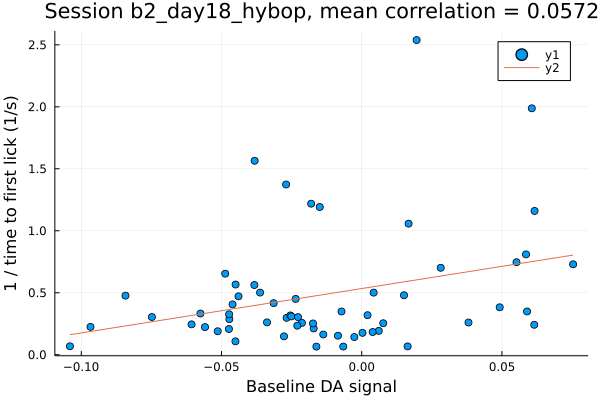

In [16]:
max_session = sessions[findmax(baseline_corr)[2]]
idx = trials_all.session .== max_session

x = trials_all.da_baseline[idx]
y = @. 1.0 / (trials_all.lick[idx] - trials_all.cue[idx])

ols = lm(@formula(Y ~ X), DataFrame(X=x, Y=y))
xhat = LinRange(minimum(x), maximum(x), length(x))
yhat = predict(ols, DataFrame(X=xhat))

scatter(x, y)
plot!(xhat, yhat)
title!("Session $(max_session), mean correlation = $(round(mean(baseline_corr),digits=4))")
xlabel!("Baseline DA signal")
ylabel!("1 / time to first lick (1/s)")

### Per-mouse and aggregate

H14 and H15 are excluded because most trials that should be rewarded are not (and other artifacts).

In [17]:
mice = unique(map(s -> uppercase(s[1:2]), sessions));

In [71]:
remove_baseline = true
lickbin = [3.3, 7]
reverse = false
;

In [72]:
coefs = zeros(nbins, length(mice))
errors = zeros(nbins, length(mice))

for (m, mouse) in enumerate(mice)
    df = similar(da_bins_all, 0)
    df.a = Float64[]
    
    mouse_sessions = filter(s -> startswith(uppercase(s), mouse), sessions)
    for session in mouse_sessions
        trialidx = findall(trials_all.session .== session)

        trials  = trials_all[trialidx, :] |> copy
        da_bins = da_bins_all[trialidx, :] |> copy
        if remove_baseline
             da_bins .-= trials.da_baseline
        end

        lickbin_idx = findall(lickbin[1] .< trials.lick .- trials.cue .< lickbin[2])
        if length(lickbin_idx) == 0; continue; end

        if lickbin_idx[1] == 1; popfirst!(lickbin_idx); end
        if length(lickbin_idx) == 0; continue; end

        if lickbin_idx[end] == nrow(trials); pop!(lickbin_idx); end
        if length(lickbin_idx) == 0; continue; end

        indexes = lickbin_idx[(trials.trial[lickbin_idx.+1] .- trials.trial[lickbin_idx] .== 1)]
        
        Δda_slopes = diff(trials.da_slope)[indexes]
        if reverse
            Δda_slopes .*= -1
            indexes .+= 1
        end

        dfsession = da_bins[indexes,:]
        dfsession.a = Δda_slopes
        
        append!(df, dfsession)
    end
    
    formula = Term(:a) ~ ConstantTerm(0) + sum(Term.(Symbol.(names(da_bins_all))))
    ols     = lm(formula, df)
    coefs[:,m]  = replace(coef(ols),     NaN => 0)
    errors[:,m] = replace(stderror(ols), NaN => 0)
end
;

In [73]:
(x[5], x[10])

(-4.675, -0.425)

In [74]:
ttest = OneSampleTTest(
    coefs[5,:], # around mean(lickbin)
    coefs[10,:],
)

One sample t-test
-----------------
Population details:
    parameter of interest:   Mean
    value under h_0:         0
    point estimate:          0.158686
    95% confidence interval: (0.0476, 0.2698)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.0110

Details:
    number of observations:   9
    t-statistic:              3.2938920886071386
    degrees of freedom:       8
    empirical standard error: 0.04817581307473872


In [70]:
ttest = OneSampleTTest(
    coefs[5,:],
    coefs[10,:],
)

One sample t-test
-----------------
Population details:
    parameter of interest:   Mean
    value under h_0:         0
    point estimate:          0.127949
    95% confidence interval: (-0.0538, 0.3097)

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.1432

Details:
    number of observations:   9
    t-statistic:              1.6232037266134778
    degrees of freedom:       8
    empirical standard error: 0.0788250091387893


In [21]:
pvalue(ttest)

1.1154870312263265e-5

In [96]:
pvalue(ttest)

0.8971480752089774

In [130]:
df = similar(da_bins_all, 0)
df.a = Float64[]

for session in sessions
    trialidx = findall(trials_all.session .== session)
    
    trials  = trials_all[trialidx, :] |> copy
    da_bins = da_bins_all[trialidx, :] |> copy
    if remove_baseline
         da_bins .-= trials.da_baseline
    end
    
    lickbin_idx = findall(lickbin[1] .< trials.lick .- trials.cue .< lickbin[2])
    if length(lickbin_idx) == 0; continue; end
    
    if lickbin_idx[1] == 1; popfirst!(lickbin_idx); end
    if length(lickbin_idx) == 0; continue; end
    
    if lickbin_idx[end] == nrow(trials); pop!(lickbin_idx); end
    if length(lickbin_idx) == 0; continue; end
    
    indexes = lickbin_idx[(trials.trial[lickbin_idx.+1] .- trials.trial[lickbin_idx] .== 1)]

    Δda_slopes = diff(trials.da_slope)[indexes]
    if reverse
        Δda_slopes .*= -1
        indexes .+= 1
    end
    
    dfsession = da_bins[indexes,:]
    dfsession.a = Δda_slopes
    
    append!(df, dfsession)
end

formula = Term(:a) ~ ConstantTerm(0) + sum(Term.(Symbol.(names(da_bins_all))))
ols     = lm(formula, df)
coef_agg  = replace(coef(ols),     NaN => 0)
error_agg = replace(stderror(ols), NaN => 0)
;

In [22]:
bins = get_bins(-mean(lickbin), 0, nbins, AbsBin(), AlignLick())
x = (bins[1:end-1] + bins[2:end]) / 2.0
;

In [77]:
pyplot()

Plots.PyPlotBackend()

In [80]:
gr()

Plots.GRBackend()

In [112]:
smooth_arr(arr) = smooth(arr, :rect, 3)
smooth_mat(mat; dims=[1]) = mapslices(smooth_arr, mat; dims=dims);

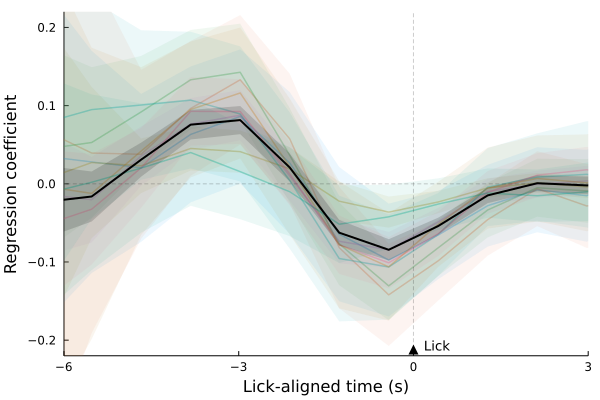

In [131]:
xlim=(-6, 3)
ylim=(-0.22, 0.22)

annotation_margin_x = 0.2
annotation_margin_y = 0.008

p_agg_forward = plot(x, coefs |> smooth_mat,
    ribbon=errors |> smooth_mat,
    labels=hcat(mice...),
    linewidth=1.5,
    fillalpha=0.075,
    opacity=0.35)

plot!(x, coef_agg |> smooth_arr,
    ribbon=error_agg |> smooth_arr,
    label="All",
    linewidth=2,
    color=:black,
    fillalpha=0.15,)


# Vertical lines at cue and lick time
vline!([0],
    color=:black,
    opacity=0.2,
    linestyle=:dash,
    label="")

# Horizontal line at x = 0
hline!([0],
    color=:black,
    opacity=0.2,
    linestyle=:dash,
    label="")

# Lick annotation
scatter!([0], [ylim[1] + annotation_margin_y],
    markershape = :utriangle,
    markersize = 5,
    markeralpha = 1,
    markercolor = :black,
    markerstrokewidth = 1,
    markerstrokealpha = 1,
    markerstrokecolor = :black,
    label="")
annotate!(annotation_margin_x, ylim[1] + annotation_margin_y + 0.005,
    text("Lick", :black, :left, 9, fontfamily))

# Axis labels
xlabel!("Lick-aligned time (s)")
ylabel!("Regression coefficient")

plot!(xlim=xlim,
    ylim=ylim,
    grid=:off,
    legend=nothing)


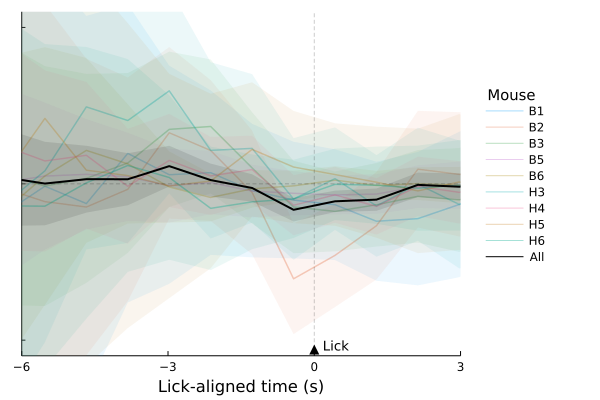

In [127]:
p_agg_reverse = plot(x, coefs |> smooth_mat,
    ribbon=errors |> smooth_mat,
    labels=hcat(mice...),
    linewidth=1.5,
    fillalpha=0.075,
    opacity=0.35)

plot!(x, coef_agg |> smooth_arr,
    ribbon=error_agg |> smooth_arr,
    label="All",
    linewidth=2,
    color=:black,
    fillalpha=0.1,)

# Vertical lines at cue and lick time
vline!([0],
    color=:black,
    opacity=0.2,
    linestyle=:dash,
    label="")

# Horizontal line at x = 0
hline!([0],
    color=:black,
    opacity=0.2,
    linestyle=:dash,
    label="")

# Lick annotation
scatter!([0], [ylim[1] + annotation_margin_y],
    markershape = :utriangle,
    markersize = 5,
    markeralpha = 1,
    markercolor = :black,
    markerstrokewidth = 1,
    markerstrokealpha = 1,
    markerstrokecolor = :black,
    label="")
annotate!(annotation_margin_x, ylim[1] + annotation_margin_y + 0.005,
    text("Lick", :black, :left, 9, fontfamily))

# Axis labels
xlabel!("Lick-aligned time (s)")

plot!(xlim=xlim,
    ylim=ylim,
    grid=:off,
    legend=:outerright,
    legendtitle="Mouse",
    legendtitlefont=font(10, :right),
    legendfontvalign=:top,
    foreground_color_legend=nothing,
    yticks=([-0.4, -0.2, 0, 0.2, 0.4], ["", "", "", "", ""]),
)

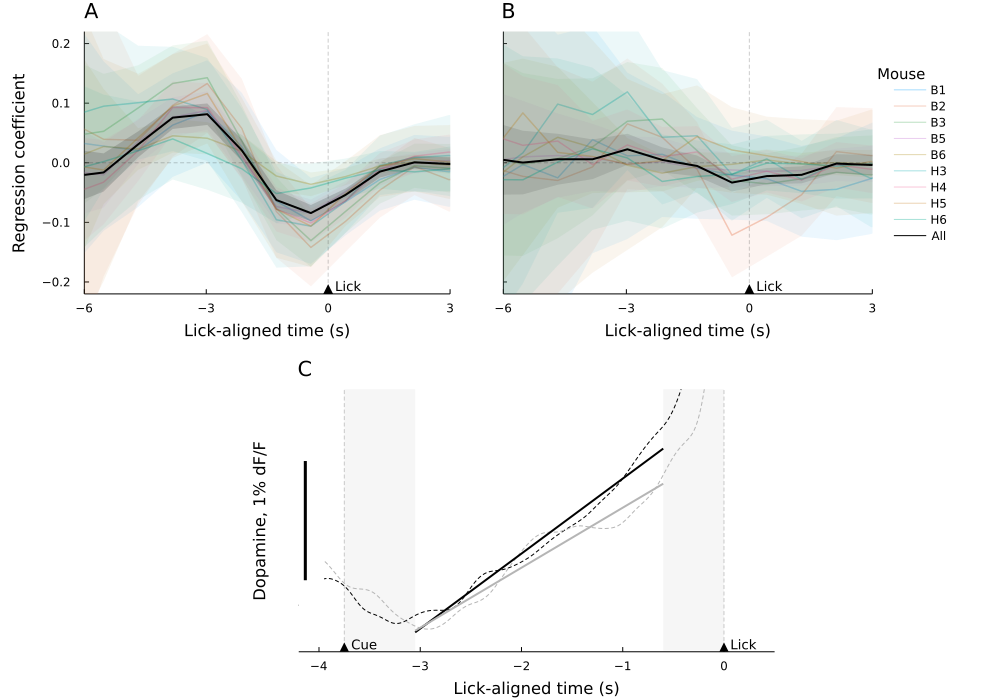

In [135]:
title!(p_agg_forward, "A")
title!(p_agg_reverse, "B")

p_agg = plot(p_agg_forward, p_agg_reverse,
    titlelocation=:left,
    layout=@layout([a{0.43w} b{0.57w}]),
)

plot!(p_agg, bottom_margin=5Plots.mm, left_margin=5Plots.mm)

pblank = plot(legend=false, grid=false, foreground_color_subplot=:white)

title!(pslope, "C")


p_final = plot(p_agg, pblank, pslope, pblank,
    titlelocation=:left,
    layout=@layout([a; b{0.2w} c{0.6w} d{0.2w}]),
    size=(1000, 700),
)

In [136]:
savefig("figs/fig_bidirectional_empirical_3panel.pdf")

#### Mouse-per-mouse

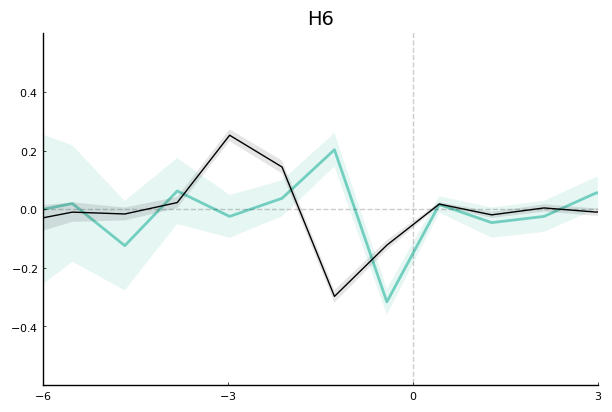

In [153]:
for (m, mouse) in enumerate(mice)
    plot(x, coefs_smooth[:,m],
        ribbon=errors_smooth[:,m],
        label="",
        color=m,
        linewidth=2,
        fillalpha=0.1,
        opacity=0.5)
    
    plot!(x, smooth_mouse(y),
        ribbon=smooth_mouse(stderr),
        label="",
        color=:black,
        fillalpha=0.1,)
    
    title!(mouse)
    
    # Vertical lines at cue and lick time
    vline!([0],
        color=:black,
        opacity=0.2,
        linestyle=:dash,
        label="")

    # Horizontal line at x = 0
    hline!([0],
        color=:black,
        opacity=0.2,
        linestyle=:dash,
        label="")

    plot!(xlim=(-6, 3),
        ylim=(-0.6, 0.6),
        linewidth=2,
        grid=:off)
    
    savefig("figs/mice/$mouse.png")
end
;

### Bidirectional dependency (empirical): final figure

In [90]:
remove_baseline = true

df = similar(da_bins_all, 0)
df.a = Float64[]
df.slope = Float64[]
df.is_rewarded = CategoricalValue[]
df.lick = CategoricalValue[]
df.licktime = Float64[]
df.da_beg = Float64[]
df.da_end = Float64[]

lickbin = [3.3, 7] # (3.5, 4)
key = "trials without gaps"
reverse = false
fraction = (0.0, 1.0)
rewarded_only = false

ns = []
lickdiff = []

for session in sessions
    trialidx = trials_all.session .== session
    ntrials = sum(trialidx)
    
    trialidx = findall(trialidx .& (ntrials*fraction[1] .< trials_all.trial .< ntrials*fraction[2])) 
    
    trials  = trials_all[trialidx, :] |> copy
    da_bins = da_bins_all[trialidx, :] |> copy
    if remove_baseline
         da_bins .-= trials.da_baseline
    end
    
    lickbin_idx = (lickbin[1] .< trials.lick .- trials.cue .< lickbin[2])
    if rewarded_only; lickbin_idx .&= trials.is_rewarded; end
    lickbin_idx = findall(lickbin_idx)
    if length(lickbin_idx) == 0; continue; end
    
    if lickbin_idx[1] == 1; popfirst!(lickbin_idx); end
    if length(lickbin_idx) == 0; continue; end
    
    if lickbin_idx[end] == nrow(trials); pop!(lickbin_idx); end
    if length(lickbin_idx) == 0; continue; end
    
    indexes = lickbin_idx
    if key == "trials without gaps"
        indexes = lickbin_idx[(trials.trial[lickbin_idx.+1] .- trials.trial[lickbin_idx] .== 1)]
        # .& trials.is_rewarded[lickbin_idx.+1]
    elseif key == "all trials"
        indexes = lickbin_idx
    else
        @error "Unknown analysis key"
        break
    end
    
    push!(ns, length(indexes))

    Δda_slopes = diff(trials.da_slope)[indexes]
    ldiff = diff(trials.lick - trials.cue)[indexes]
    #if reverse; Δda_slopes = vcat(0, trials.da_slope[1:end-1]) - trials.da_slope[1:end]; end
    
    if reverse
        Δda_slopes .*= -1
        indexes .+= 1
        ldiff .*= -1
    end
    
    append!(lickdiff, ldiff)
    
    dfsession = da_bins[indexes,:]
    dfsession.slope = trials.da_slope[indexes]
    dfsession.a = Δda_slopes
    dfsession.is_rewarded = categorical(Int.(trials.is_rewarded[indexes]))
    
    dfsession.lick = categorical(
        map(indexes) do i
            licktime = trials.lick[i] - trials.cue[i]
            # reaction
            if 0 < licktime < 0.5
                return 0
            # early
            elseif 0.5 < licktime < 3.3
                return 1
            # reward
            elseif 3.3 < licktime < 7
                return 2
            # iti
            elseif 7 < licktime < 17
                return 3
            # no lick
            else
                return 4
            end
        end
    )
    
    dfsession.licktime = (trials.lick - trials.cue)[indexes]
    dfsession.da_end = trials.da_end[indexes]
    dfsession.da_beg = trials.da_start[indexes]
    
    append!(df, dfsession)
end

println(sum(ns))
;

4051


In [43]:
p = plot();

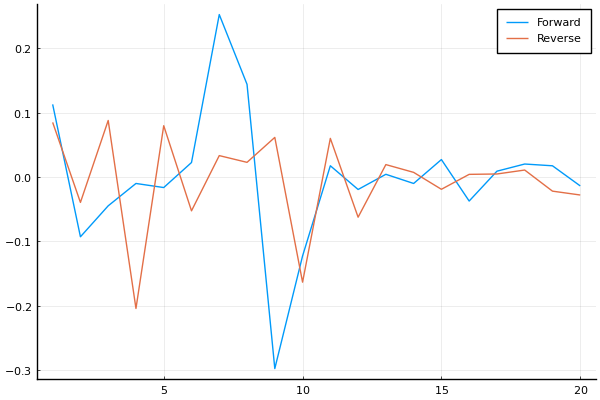

In [46]:
direction = reverse ? "Reverse" : "Forward"

sm_plot(y) = smooth(y, :rect, 1)

formula = Term(:a) ~ ConstantTerm(0) + sum(Term.(Symbol.(names(da_bins_all))))

ols     = lm(formula, df)
plot!(p, coef(ols) |> sm_plot, label="$direction")

In [256]:
pyplot()

Plots.PyPlotBackend()

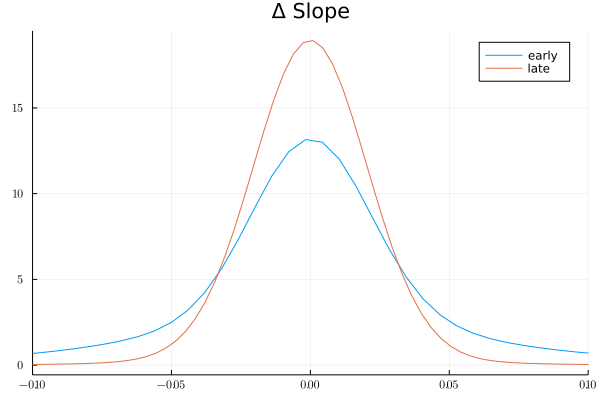

In [259]:
plot(p2)
plot!(linewidth=2)

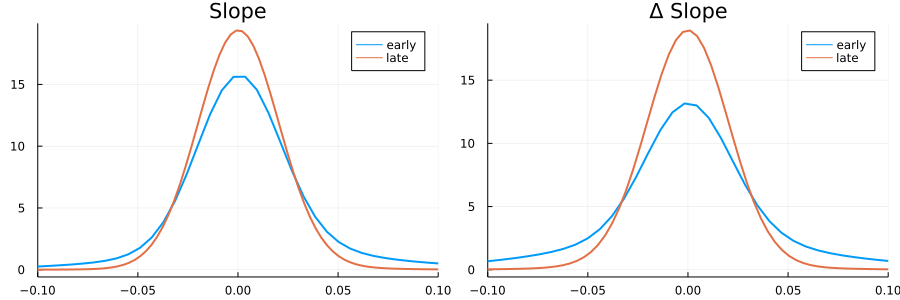

In [57]:
p1 = density(dfearly.slope, bandwidth=0.02, label="early")
density!(dflate.slope, bandwidth=0.02, label="late")
title!("Slope")
plot!(xlim=(-0.1, 0.1))

p2 = density(dfearly.a, bandwidth=0.02, label="early")
density!(dflate.a, bandwidth=0.02, label="late")
title!("Δ Slope")
plot!(xlim=(-0.1, 0.1))

plot(p1, p2, size=(900, 300), layout = @layout([ a b ]), linewidth=2)

In [58]:
savefig("figs/bleaching.png")

### Early trials

In [34]:
ols = lm(@formula(a ~ 0 + is_rewarded), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

a ~ 0 + is_rewarded

Coefficients:
────────────────────────────────────────────────────────────────────────────────────
                      Coef.   Std. Error      t  Pr(>|t|)    Lower 95%     Upper 95%
────────────────────────────────────────────────────────────────────────────────────
is_rewarded: 1  -0.00248368  0.000460631  -5.39    <1e-07  -0.00338677  -0.00158059
is_rewarded: 0  -0.00569624  0.00261405   -2.18    0.0294  -0.0108212   -0.000571268
────────────────────────────────────────────────────────────────────────────────────

In [246]:
ols = lm(@formula(a ~ 0 + lick), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

a ~ 0 + lick

Coefficients:
───────────────────────────────────────────────────────────────────────────
               Coef.  Std. Error      t  Pr(>|t|)    Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────
lick: 0   0.00676673  0.00216733   3.12    0.0018   0.00251693  0.0110165
lick: 2  -0.00650891  0.0041853   -1.56    0.1200  -0.0147156   0.00169781
lick: 3  -0.00314093  0.016082    -0.20    0.8452  -0.0346752   0.0283933
lick: 1  -0.00270509  0.00171549  -1.58    0.1149  -0.00606889  0.000658721
───────────────────────────────────────────────────────────────────────────

### Late trials

In [95]:
ols = lm(@formula(a ~ 0 + is_rewarded), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

a ~ 0 + is_rewarded

Coefficients:
────────────────────────────────────────────────────────────────────────────────────
                       Coef.   Std. Error      t  Pr(>|t|)    Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────────────
is_rewarded: 0   0.000436871  0.000233964   1.87    0.0619  -2.17084e-5   0.00089545
is_rewarded: 1  -0.00248115   0.000593692  -4.18    <1e-04  -0.00364481  -0.00131749
────────────────────────────────────────────────────────────────────────────────────

In [240]:
ols = lm(@formula(a ~ 0 + lick), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

a ~ 0 + lick

Coefficients:
──────────────────────────────────────────────────────────────────────────────
                Coef.   Std. Error      t  Pr(>|t|)    Lower 95%     Upper 95%
──────────────────────────────────────────────────────────────────────────────
lick: 1   0.000333716  0.000398454   0.84    0.4024  -0.00044762   0.00111505
lick: 2  -0.00182909   0.000593355  -3.08    0.0021  -0.00299261  -0.000665572
lick: 3   0.00425488   0.00157402    2.70    0.0069   0.00116836   0.0073414
lick: 0  -5.83227e-5   0.000593876  -0.10    0.9218  -0.00122287   0.00110622
──────────────────────────────────────────────────────────────────────────────

### Good mouse

In [280]:
dir = "B5_signalname_15"

fname, matfile = load_matfile(dir)
exclusions = load_exclusions(dir)

trials, da_signal = get_avg_trials(fname, matfile, exclusions=exclusions, verbose=0);

LoadError: MethodError: no method matching -(::Vector{Float64}, ::Float64)
For element-wise subtraction, use broadcasting with dot syntax: array .- scalar
[0mClosest candidates are:
[0m  -([91m::LinearAlgebra.UniformScaling[39m, ::Number) at C:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.6\LinearAlgebra\src\uniformscaling.jl:147
[0m  -(::Array, [91m::SparseArrays.AbstractSparseMatrixCSC[39m) at C:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.6\SparseArrays\src\sparsematrix.jl:1747
[0m  -(::Array{T, N}, [91m::FillArrays.Zeros{V, N, Axes} where Axes[39m) where {T, V, N} at C:\Users\antho\.julia\packages\FillArrays\tZT1x\src\fillalgebra.jl:193
[0m  ...

In [210]:
padding = 0.5
padding_ms = round(Int, padding * 1000);

In [211]:
maxlen = maximum(length(s) for s in da_signal)
da_mat_cue  = zeros(Union{Missing, Float64}, length(da_signal), maxlen)
da_mat_lick = zeros(Union{Missing, Float64}, length(da_signal), maxlen)

smoothing(y) = smooth(y, :hamming, 100)

for i in 1:length(da_signal)
    licktime = trials.lick[i] - trials.cue[i]
    da_mat_cue[i,1:length(da_signal[i])] .= da_signal[i] |> smoothing

    i_lick_beg = padding_ms + round(Int, licktime*1000)
    i_lick_end = min(i_lick_beg + padding_ms, length(da_signal[i]))
    da_mat_lick[i,end-i_lick_end+1:end] .= da_signal[i][1:i_lick_end] |> smoothing
end

replace!(da_mat_cue, 0.0 => missing)
replace!(da_mat_lick, 0.0 => missing)
;

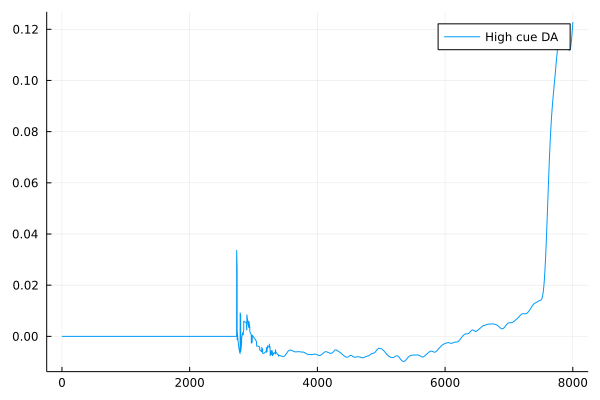

In [70]:
lickbin = [3.6, 4.3]
lickbintrials = lickbin[1] .< trials.lick .- trials.cue .< lickbin[2]

# current trial
p1 = plot(damatmean(da_mat_lick[lickbintrials,:]), label="High cue DA")

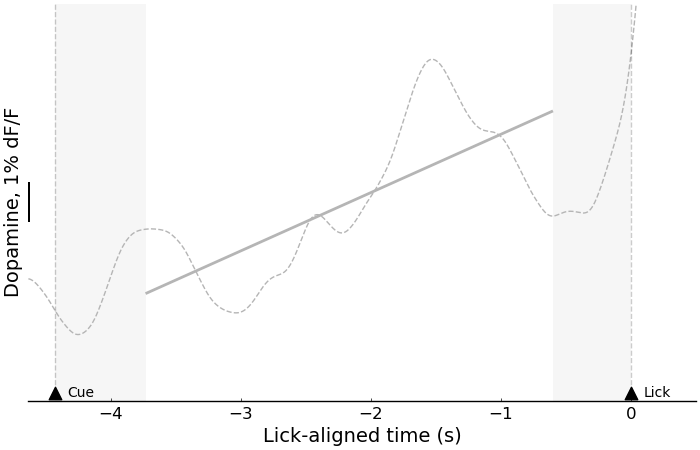

In [192]:
x = LinRange(-size(da_mat_lick,2) / 1000.0 + 0.5, 0.5, size(da_mat_lick,2))
smooth_plot(y) = smooth(y, :rect, 201)

lick = trials.lick[i] - trials.cue[i]

# after
ylick = 100 * (da_mat_lick[i,:] .- trials.da_baseline[i])
replace!(ylick, missing => 0)
ylick = convert.(Float64, ylick)

xlen = round(Int, lick*1000 - 1300)

if xlen <= 0
    @warn "Lick too early"
else

    xlick = ones(xlen,2)
    xlick[:,2] = collect(LinRange(-lick+0.7, -0.6, xlen))

    ylickfit = ylick[end-padding_ms-round(Int,lick*1000)+700+1:end-padding_ms-600]
    olslick = fit(LinearModel, xlick, ylickfit)

    xlim=(-lick - 0.2, 0.5)
    ylim=(-5, 5) .+ predict(olslick, xlick)[div(size(xlick,1),2)]

    annotation_margin_x = 0.1
    annotation_margin_y = (ylim[2] - ylim[1]) / 50

    c1 = colorant"#00b894"
    c2 = colorant"#e17055"

    c1 = :black      # colorant"#00b894"
    c2 = colorant"#b5b5b5" # colorant"#e17055"

    # buffer rectangles
    crect = colorant"#f6f6f6"

    plot(rectangle(-buffer_post_cue,ylim[2]-ylim[1],-lick+buffer_post_cue,ylim[1]),
        color=crect,
        linecolor=nothing,
        label="")

    plot!(rectangle(buffer_pre_lick,ylim[2]-ylim[1],-buffer_pre_lick,ylim[1]),
        color=crect,
        linecolor=nothing,
        label="")

    # thin DA signal
    plot!(x, ylick |> smooth_plot,
        color=c2,
        linewidth=1,
        linestyle=:dash,
        label="" # "After high lick DA",
    )

    # slope
    plot!(xlick[:,2], predict(olslick, xlick),
        label="",#string(round(coef(olslick)[2], digits=5)),
        color=c2,
        linewidth=2,
        linestyle=:solid,)

    # Annotations
    # Cue annotation
    vline!([-lick],
        color=:black,
        opacity=0.2,
        linestyle=:dash,
        label="",
    )
    scatter!([-lick], [ylim[1] + annotation_margin_y],
        markershape = :utriangle,
        markersize = 9,
        markeralpha = 1,
        markercolor = :black,
        markerstrokewidth = 1,
        markerstrokealpha = 1,
        markerstrokecolor = :black,
        label="")
    annotate!(-lick + annotation_margin_x, ylim[1] + annotation_margin_y,
        text("Cue", :black, :left, 10))

    # Lick annotation
    vline!([0],
        color=:black,
        opacity=0.2,
        linestyle=:dash,
        label="",
    )
    scatter!([0], [ylim[1] + annotation_margin_y],
        markershape = :utriangle,
        markersize = 9,
        markeralpha = 1,
        markercolor = :black,
        markerstrokewidth = 1,
        markerstrokealpha = 1,
        markerstrokecolor = :black,
        label="")
    annotate!(-0 + annotation_margin_x, ylim[1] + annotation_margin_y,
        text("Lick", :black, :left, 10))

    # Scale annotation
    #plot!(rectangle(0.4, 1, -lick - 0.5, ylim[1]+0.1),
    #    color=:white,
    #    linecolor=nothing,
    #    label="")

    plot!(rectangle(0.05 / (xlim[2] - xlim[1]), 1, -lick - 0.2, mean(ylim)-0.5),
        color=:black,
        linecolor=nothing,
        label="")

    plot!(
        legend=nothing,
        grid=:off,
        size=(700, 450),
        xlim=xlim,
        ylim=ylim,
        xlabel="Lick-aligned time (s)",
        ylabel="Dopamine, 1% dF/F",
        yaxis=false,
        #yticks=nothing,
        guidefont=font(guidefontsize, fontfamily),
        tickfont=font(tickfontsize, fontfamily),
    )
end

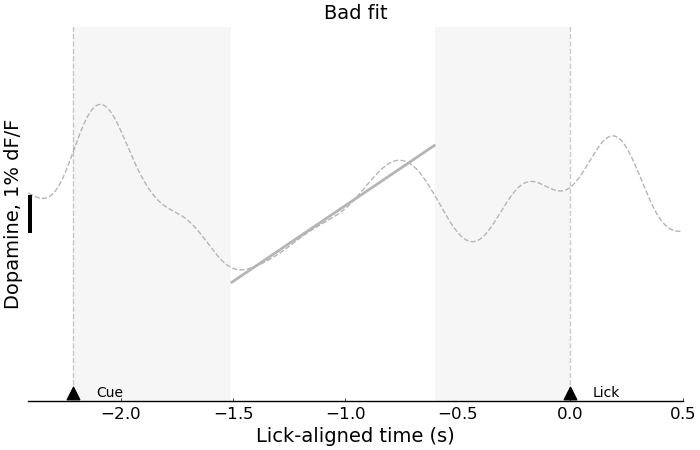

In [193]:
title!(pgood, "Good fit")
title!(pbad, "Bad fit")

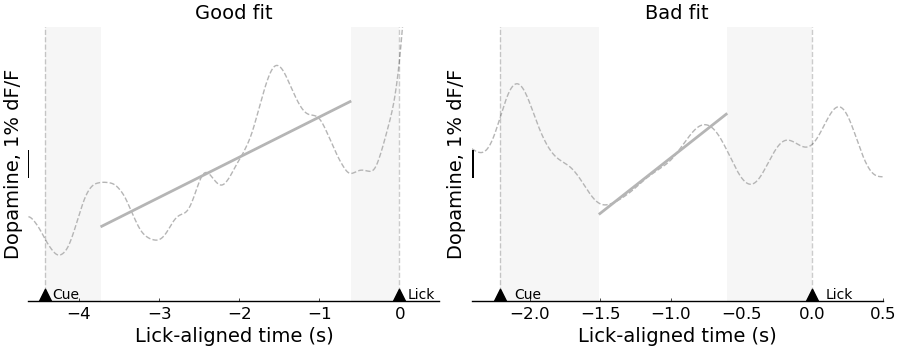

In [197]:
plot(pgood, pbad, size=(900, 350), layout = @layout([a b]))

In [198]:
savefig("figs/discussion/slope_fit.png")

In [203]:
names(trials)

12-element Vector{String}:
 "session"
 "trial"
 "lamp_off"
 "cue"
 "lamp_on"
 "lick"
 "is_rewarded"
 "da_baseline"
 "da_start"
 "da_end"
 "da_max"
 "da_slope"

In [283]:
mean(trials[trials.da_end .> trials.da_start, :da_slope] .> 0)

0.45384615384615384

In [281]:
ttt = trials[trials.da_slope .> 0, :]
mean(ttt.da_end .- ttt.da_start .> 0)

0.6483516483516484

In [276]:
mean((trials.da_max .> trials.da_baseline) .& (trials.da_slope .> 0))

0.22459893048128343

In [248]:
dir = "B5_signalname_15"

fname, matfile = load_matfile(dir)
exclusions = load_exclusions(dir)

trials, da_bins = load_trials(fname, matfile, exclusions=exclusions, use_cache=false, save_cache=false, verbose=1);

Loading b5_day15_hybop0 from scratch...
No lick found for cue 253
No lick found for cue 254
No lick found for cue 255
No lick found for cue 296
No lick found for cue 339
No lick found for cue 379
No lick found for cue 424
No lick found for cue 520
No lick found for cue 576
No lick found for cue 622
No lick found for cue 625
No lick found for cue 634
No lick found for cue 644
No lick found for cue 693
No lick found for cue 718
No lick found for cue 721
No lick found for cue 737
No lick found for cue 744
No lick found for cue 746
No lick found for cue 748
No lick found for cue 752
No lick found for cue 753
No lick found for cue 756
No lick found for cue 758
No lick found for cue 759
No lick found for cue 760
No lick found for cue 761
No lick found for cue 762
No lick found for cue 763
No lick found for cue 765
No lick found for cue 766
No lick found for cue 767
No lick found for cue 769
No lick found for cue 772
No lick found for cue 773
No lick found for cue 774
No lick found for cue 77

In [29]:
remove_baseline = true
reverse = false
lickbin = (3.3, 4) # (3.5, 4)
fraction = (0.0, 1.0)

ntrials = nrow(trials)

indexes = findall((lickbin[1] .< trials.lick .- trials.cue .< lickbin[2]) .& (ntrials*fraction[1] .< trials.trial .< ntrials*fraction[2]))
if indexes[end] == nrow(trials); pop!(indexes); end
if indexes[1] == 1; popfirst!(indexes); end

indexes = indexes[trials.trial[indexes .+ 1] .- trials.trial[indexes] .== 1]

Δda_slopes = diff(trials.da_slope)

da = copy(da_bins)
if remove_baseline
    da .-= trials.da_baseline
end

if reverse
    Δda_slopes .*= -1
    indexes .+= 1
end

df = da[indexes,:]
df.a = Δda_slopes[indexes]

df.is_rewarded = categorical(Int.(trials.is_rewarded[indexes]))
    
df.lick = categorical(
    map(indexes) do i
        licktime = trials.lick[i] - trials.cue[i]
        # reaction
        if 0 < licktime < 0.5
            return 0
        # early
        elseif 0.5 < licktime < 3.3
            return 1
        # reward
        elseif 3.3 < licktime < 7
            return 2
        # iti
        elseif 7 < licktime < 17
            return 3
        # no lick
        else
            return 4
        end
    end
)
;

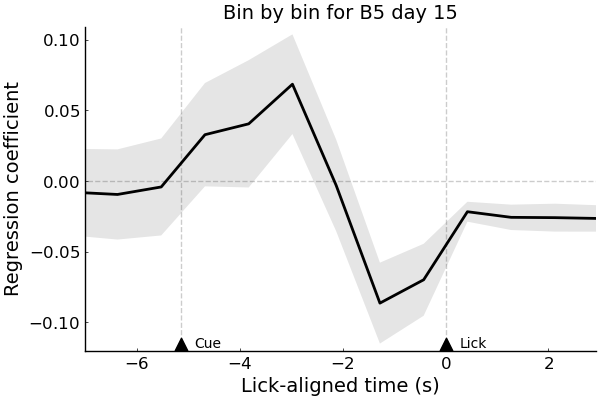

In [253]:
coef_single = [coef(lm(Term(:a) ~ ConstantTerm(0) + Term(Symbol("x$i")), df))[1] for i in 1:nbins]
err_single = [stderror(lm(Term(:a) ~ ConstantTerm(0) + Term(Symbol("x$i")), df))[1] for i in 1:nbins]

bins = get_bins(-mean(lickbin), 0, nbins, AbsBin(), AlignLick())
x = (bins[1:end-1] + bins[2:end]) / 2.0

wintype, win = :rect, 1

yplot = smooth(coef_single, wintype, win)
eplot = smooth(err_single,  wintype, win)

margin_y = 0.005

xlim = (-7, 4 + (7 - maximum(x))) # (minimum(x), maximum(x))
ylim = (minimum(yplot - eplot) - margin_y, maximum(yplot + eplot) + margin_y)

# Bidirectional dependency
pupdate = plot(x, yplot, ribbon=eplot,
    xlim=xlim,
    ylim=ylim,
    color=:black,
    fillalpha=0.1,
    linewidth=2,
    grid=:off,
    label="")

# Vertical lines at cue and lick time
vline!([-mean(lickbin), 0],
    color=:black,
    opacity=0.2,
    linestyle=:dash,
    label="")

# Horizontal line at x = 0
hline!([0],
    color=:black,
    opacity=0.2,
    linestyle=:dash,
    label="")

annotation_margin_x = 0.275
annotation_margin_y = (ylim[2] - ylim[1]) / 50

# Cue annotation
scatter!([-mean(lickbin)], [ylim[1] + annotation_margin_y],
    markershape = :utriangle,
    markersize = 9,
    markeralpha = 1,
    markercolor = :black,
    markerstrokewidth = 1,
    markerstrokealpha = 1,
    markerstrokecolor = :black,
    label="")
annotate!(-mean(lickbin) + annotation_margin_x, ylim[1] + annotation_margin_y,
    text("Cue", :black, :left, 10, fontfamily))

# Lick annotation
scatter!([0], [ylim[1] + annotation_margin_y],
    markershape = :utriangle,
    markersize = 9,
    markeralpha = 1,
    markercolor = :black,
    markerstrokewidth = 1,
    markerstrokealpha = 1,
    markerstrokecolor = :black,
    label="")
annotate!(annotation_margin_x, ylim[1] + annotation_margin_y,
    text("Lick", :black, :left, 10, fontfamily))

# Axis labels
xlabel!("Lick-aligned time (s)")
ylabel!("Regression coefficient")

xticks = [-6, -4,-2,0,2,4]
plot!(
    xticks=xticks,
    guidefont=font(guidefontsize, fontfamily),
    tickfont=font(tickfontsize, fontfamily),
)
title!("Bin by bin for B5 day 15")

In [254]:
savefig("figs/discussion/bin_by_bin_single_mouse.png")

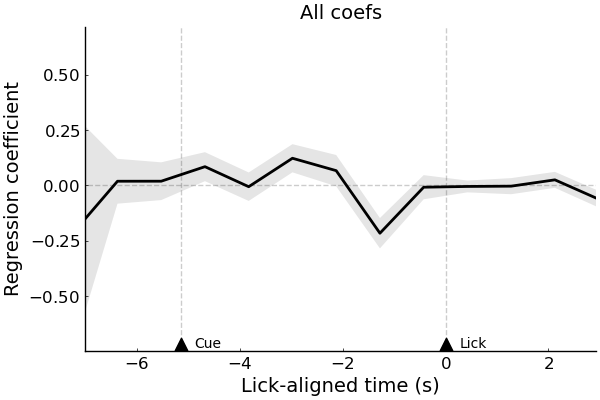

In [224]:
ols = lm(Term(:a) ~ ConstantTerm(0) + sum(Term(Symbol("x$i")) for i in 1:nbins), df)
coe = coef(ols)
err = stderror(ols)

bins = get_bins(-mean(lickbin), 0, nbins, AbsBin(), AlignLick())
x = (bins[1:end-1] + bins[2:end]) / 2.0

wintype, win = :rect, 1

yplot = smooth(coe, wintype, win)
eplot = smooth(err, wintype, win)

margin_y = 0.005

xlim = (-7, 4 + (7 - maximum(x))) # (minimum(x), maximum(x))
ylim = (minimum(yplot - eplot) - margin_y, maximum(yplot + eplot) + margin_y)

# Bidirectional dependency
pupdate = plot(x, yplot, ribbon=eplot,
    xlim=xlim,
    ylim=ylim,
    color=:black,
    fillalpha=0.1,
    linewidth=2,
    grid=:off,
    label="")

# Vertical lines at cue and lick time
vline!([-mean(lickbin), 0],
    color=:black,
    opacity=0.2,
    linestyle=:dash,
    label="")

# Horizontal line at x = 0
hline!([0],
    color=:black,
    opacity=0.2,
    linestyle=:dash,
    label="")

annotation_margin_x = 0.275
annotation_margin_y = (ylim[2] - ylim[1]) / 50

# Cue annotation
scatter!([-mean(lickbin)], [ylim[1] + annotation_margin_y],
    markershape = :utriangle,
    markersize = 9,
    markeralpha = 1,
    markercolor = :black,
    markerstrokewidth = 1,
    markerstrokealpha = 1,
    markerstrokecolor = :black,
    label="")
annotate!(-mean(lickbin) + annotation_margin_x, ylim[1] + annotation_margin_y,
    text("Cue", :black, :left, 10, fontfamily))

# Lick annotation
scatter!([0], [ylim[1] + annotation_margin_y],
    markershape = :utriangle,
    markersize = 9,
    markeralpha = 1,
    markercolor = :black,
    markerstrokewidth = 1,
    markerstrokealpha = 1,
    markerstrokecolor = :black,
    label="")
annotate!(annotation_margin_x, ylim[1] + annotation_margin_y,
    text("Lick", :black, :left, 10, fontfamily))

# Axis labels
xlabel!("Lick-aligned time (s)")
ylabel!("Regression coefficient")

xticks = [-6, -4,-2,0,2,4]
plot!(
    xticks=xticks,
    guidefont=font(guidefontsize, fontfamily),
    tickfont=font(tickfontsize, fontfamily),
)
title!("All coefs")

In [235]:
ols = lm(@formula(a ~ 0 + lick), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

a ~ 0 + lick

Coefficients:
──────────────────────────────────────────────────────────────────────────────
                Coef.   Std. Error      t  Pr(>|t|)     Lower 95%    Upper 95%
──────────────────────────────────────────────────────────────────────────────
lick: 0   0.00138701   0.00109618    1.27    0.2062  -0.000765249  0.00353926
lick: 1  -3.2181e-5    0.000715161  -0.04    0.9641  -0.00143634   0.00137197
lick: 2  -0.00161846   0.00123869   -1.31    0.1918  -0.00405052   0.000813614
lick: 3  -0.000819693  0.0053381    -0.15    0.8780  -0.0113006    0.00966121
──────────────────────────────────────────────────────────────────────────────

In [236]:
ols = lm(@formula(a ~ 0 + is_rewarded), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

a ~ 0 + is_rewarded

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────
                       Coef.   Std. Error      t  Pr(>|t|)     Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────────
is_rewarded: 0   0.000390153  0.000592685   0.66    0.5106  -0.000773527  0.00155383
is_rewarded: 1  -0.00174334   0.00125728   -1.39    0.1660  -0.00421188   0.000725193
─────────────────────────────────────────────────────────────────────────────────────

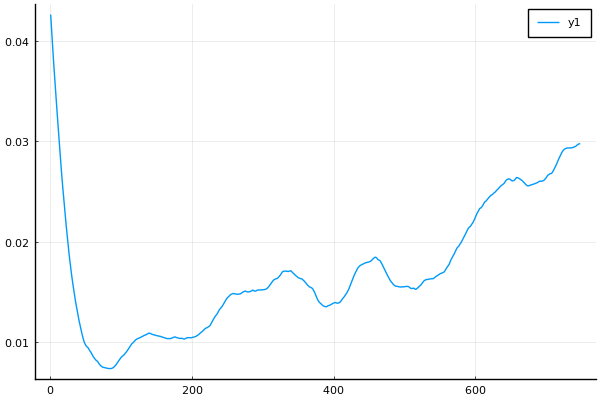

In [253]:
plot(smooth(trials.da_max .- trials.da_baseline, :rect, 50))

In [94]:
formula = Term(:a) ~ ConstantTerm(0) + sum(Term.(Symbol.(names(da_bins))))
ols     = lm(formula, df);

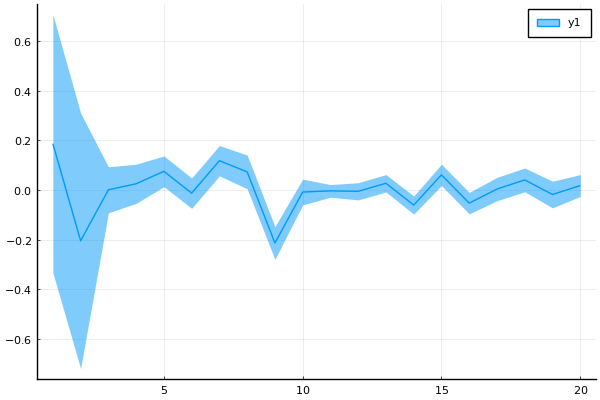

In [95]:
sm(a) = smooth(a, :rect, 1)

plot(coef(ols) |> sm, ribbon=stderror(ols) |> sm)

In [108]:
da_matrix = Matrix(da_bins[trials.is_rewarded,:]);

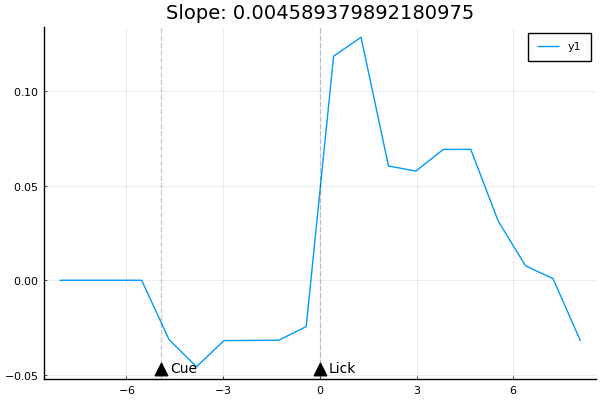

In [126]:
i = 1

tt = trials[trials.is_rewarded,:]

x = get_bins(tt.cue[i] - tt.lick[i], 0, nbins, AbsBin(), AlignLick())
x = (x[1:end-1] + x[2:end]) / 2.0

wintype, win = :rect, 1

yplot = smooth(da_matrix[i,:], wintype, win)

margin_y = 0.005

xlim = (-7, 4 + (7 - maximum(x))) # (minimum(x), maximum(x))
ylim = (minimum(yplot) - margin_y, maximum(yplot) + margin_y)


annotation_margin_x = 0.275
annotation_margin_y = (ylim[2] - ylim[1]) / 50

plot(x, yplot)
title!("Slope: $(tt.da_slope[i])")

vline!([tt.cue[i] - tt.lick[i], 0],
    color=:black,
    opacity=0.2,
    linestyle=:dash,
    label="")

# Cue annotation
scatter!([tt.cue[i] - tt.lick[i]], [ylim[1] + annotation_margin_y],
    markershape = :utriangle,
    markersize = 9,
    markeralpha = 1,
    markercolor = :black,
    markerstrokewidth = 1,
    markerstrokealpha = 1,
    markerstrokecolor = :black,
    label="")
annotate!(tt.cue[i] - tt.lick[i] + annotation_margin_x, ylim[1] + annotation_margin_y,
    text("Cue", :black, :left, 10, fontfamily))

# Lick annotation
scatter!([0], [ylim[1] + annotation_margin_y],
    markershape = :utriangle,
    markersize = 9,
    markeralpha = 1,
    markercolor = :black,
    markerstrokewidth = 1,
    markerstrokealpha = 1,
    markerstrokecolor = :black,
    label="")
annotate!(annotation_margin_x, ylim[1] + annotation_margin_y,
    text("Lick", :black, :left, 10, fontfamily))


### Coef by coef

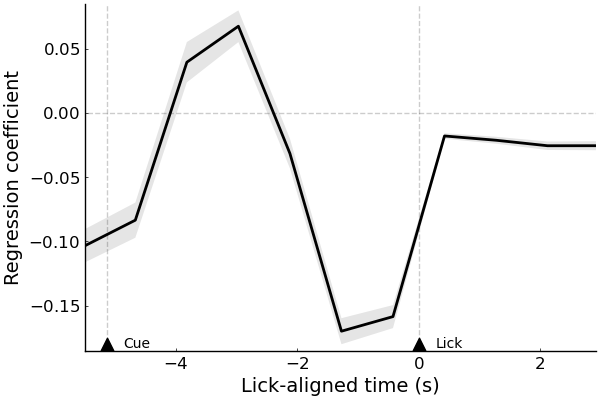

In [222]:
coef_single = [coef(lm(Term(:a) ~ ConstantTerm(0) + Term(Symbol("x$i")), df))[1] for i in 1:20]
err_single = [stderror(lm(Term(:a) ~ ConstantTerm(0) + Term(Symbol("x$i")), df))[1] for i in 1:20]

bins = get_bins(-mean(lickbin), 0, nbins, AbsBin(), AlignLick())
x = (bins[1:end-1] + bins[2:end]) / 2.0

wintype, win = :rect, 1

yplot = smooth(coef_single, wintype, win)
eplot = smooth(err_single,  wintype, win)

margin_y = 0.005

xlim = (-5.5, 4 + (7 - maximum(x))) # (minimum(x), maximum(x))
ylim = (minimum(yplot - eplot) - margin_y, maximum(yplot + eplot) + margin_y)

# Bidirectional dependency
pupdate = plot(x, yplot, ribbon=eplot,
    xlim=xlim,
    ylim=ylim,
    color=:black,
    fillalpha=0.1,
    linewidth=2,
    grid=:off,
    label="")

# Vertical lines at cue and lick time
vline!([-mean(lickbin), 0],
    color=:black,
    opacity=0.2,
    linestyle=:dash,
    label="")

# Horizontal line at x = 0
hline!([0],
    color=:black,
    opacity=0.2,
    linestyle=:dash,
    label="")

annotation_margin_x = 0.275
annotation_margin_y = (ylim[2] - ylim[1]) / 50

# Cue annotation
scatter!([-mean(lickbin)], [ylim[1] + annotation_margin_y],
    markershape = :utriangle,
    markersize = 9,
    markeralpha = 1,
    markercolor = :black,
    markerstrokewidth = 1,
    markerstrokealpha = 1,
    markerstrokecolor = :black,
    label="")
annotate!(-mean(lickbin) + annotation_margin_x, ylim[1] + annotation_margin_y,
    text("Cue", :black, :left, 10, fontfamily))

# Lick annotation
scatter!([0], [ylim[1] + annotation_margin_y],
    markershape = :utriangle,
    markersize = 9,
    markeralpha = 1,
    markercolor = :black,
    markerstrokewidth = 1,
    markerstrokealpha = 1,
    markerstrokecolor = :black,
    label="")
annotate!(annotation_margin_x, ylim[1] + annotation_margin_y,
    text("Lick", :black, :left, 10, fontfamily))

# Axis labels
xlabel!("Lick-aligned time (s)")
ylabel!("Regression coefficient")

xticks = [-4,-2,0,2,4]
plot!(
    xticks=xticks,
    guidefont=font(guidefontsize, fontfamily),
    tickfont=font(tickfontsize, fontfamily),
)

In [223]:
savefig("figs/discussion/coef_bin_by_bin.png")

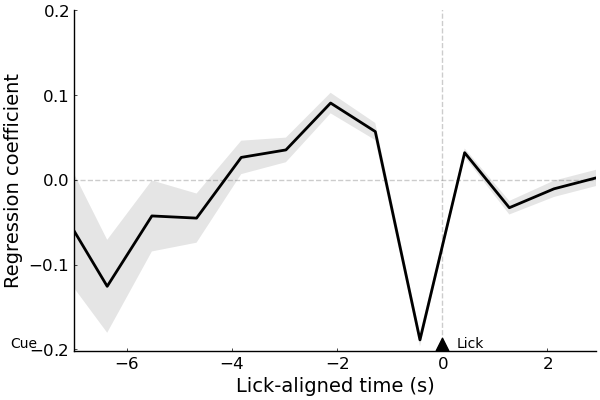

In [218]:
formula = Term(:a) ~ ConstantTerm(0) + sum(Term.(Symbol.(names(da_bins_all))))
ols     = lm(formula, df)
y       = replace(coef(ols),     NaN => 0)
err  = replace(stderror(ols), NaN => 0)

bins = get_bins(-mean(lickbin), 0, nbins, AbsBin(), AlignLick())
x = (bins[1:end-1] + bins[2:end]) / 2.0

wintype, win = :rect, 1

yplot = smooth(y, wintype, win)
eplot = smooth(err,  wintype, win)

margin_y = 0.005

xlim = (-7, 4 + (7 - maximum(x))) # (minimum(x), maximum(x))
ylim = (minimum(yplot - eplot) - margin_y, maximum(yplot + eplot) + margin_y)

# Bidirectional dependency
pupdate = plot(x, yplot, ribbon=eplot,
    xlim=xlim,
    ylim=ylim,
    color=:black,
    fillalpha=0.1,
    linewidth=2,
    grid=:off,
    label="")

# Vertical lines at cue and lick time
vline!([-mean(lickbin), 0],
    color=:black,
    opacity=0.2,
    linestyle=:dash,
    label="")

# Horizontal line at x = 0
hline!([0],
    color=:black,
    opacity=0.2,
    linestyle=:dash,
    label="")

annotation_margin_x = 0.275
annotation_margin_y = (ylim[2] - ylim[1]) / 50

# Cue annotation
scatter!([-mean(lickbin)], [ylim[1] + annotation_margin_y],
    markershape = :utriangle,
    markersize = 9,
    markeralpha = 1,
    markercolor = :black,
    markerstrokewidth = 1,
    markerstrokealpha = 1,
    markerstrokecolor = :black,
    label="")
annotate!(-mean(lickbin) + annotation_margin_x, ylim[1] + annotation_margin_y,
    text("Cue", :black, :left, 10, fontfamily))

# Lick annotation
scatter!([0], [ylim[1] + annotation_margin_y],
    markershape = :utriangle,
    markersize = 9,
    markeralpha = 1,
    markercolor = :black,
    markerstrokewidth = 1,
    markerstrokealpha = 1,
    markerstrokecolor = :black,
    label="")
annotate!(annotation_margin_x, ylim[1] + annotation_margin_y,
    text("Lick", :black, :left, 10, fontfamily))

# Axis labels
xlabel!("Lick-aligned time (s)")
ylabel!("Regression coefficient")

xticks = [-6,-4,-2,0,2,4]
plot!(
    xticks=xticks,
    guidefont=font(guidefontsize, fontfamily),
    tickfont=font(tickfontsize, fontfamily),
)

In [82]:
ols = lm(@formula(a ~ 0 + is_rewarded), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

a ~ 0 + is_rewarded

Coefficients:
────────────────────────────────────────────────────────────────────────────────────
                      Coef.   Std. Error      t  Pr(>|t|)    Lower 95%     Upper 95%
────────────────────────────────────────────────────────────────────────────────────
is_rewarded: 1  -0.00248368  0.000460631  -5.39    <1e-07  -0.00338677  -0.00158059
is_rewarded: 0  -0.00569624  0.00261405   -2.18    0.0294  -0.0108212   -0.000571268
────────────────────────────────────────────────────────────────────────────────────

In [406]:
ols = lm(@formula(a ~ 0 + is_rewarded), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

a ~ 0 + is_rewarded

Coefficients:
────────────────────────────────────────────────────────────────────────────────────
                       Coef.   Std. Error      t  Pr(>|t|)    Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────────────
is_rewarded: 0   0.000436871  0.000233964   1.87    0.0619  -2.17084e-5   0.00089545
is_rewarded: 1  -0.00248115   0.000593692  -4.18    <1e-04  -0.00364481  -0.00131749
────────────────────────────────────────────────────────────────────────────────────

In [94]:
ols = lm(@formula(a ~ 0 + lick), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

a ~ 0 + lick

Coefficients:
───────────────────────────────────────────────────────────────────────────────
                Coef.   Std. Error      t  Pr(>|t|)     Lower 95%     Upper 95%
───────────────────────────────────────────────────────────────────────────────
lick: 0   3.77399e-5   0.000395945   0.10    0.9241  -0.000738474   0.000813954
lick: 1   0.000287611  0.000262696   1.09    0.2736  -0.000227381   0.000802602
lick: 2  -0.00141163   0.000410032  -3.44    0.0006  -0.00221546   -0.000607795
lick: 3   0.00126023   0.00112959    1.12    0.2646  -0.000954239   0.00347469
───────────────────────────────────────────────────────────────────────────────

In [92]:
# forward
formula = Term(:a) ~ ConstantTerm(0) + sum(Term.(Symbol.(names(da_bins_all)))) + Term(:is_rewarded)
ols     = lm(formula, df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

a ~ 0 + x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9 + x10 + x11 + x12 + x13 + x14 + x15 + x16 + x17 + x18 + x19 + x20 + is_rewarded

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────
                       Coef.   Std. Error       t  Pr(>|t|)    Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────────
x1               0.0899333    0.174653       0.51    0.6066  -0.252395     0.432262
x2              -0.0720512    0.175778      -0.41    0.6819  -0.416584     0.272481
x3              -0.0664419    0.0720118     -0.92    0.3562  -0.207588     0.0747046
x4              -0.0620696    0.046596      -1.33    0.1828  -0.1534       0.0292606
x5              -0.0355819    0.0307031     -1.16    0.2465  -0.0957615    0.024

In [361]:
# reverse
formula = Term(:a) ~ ConstantTerm(0) + sum(Term.(Symbol.(names(da_bins_all))))
ols     = lm(formula, df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

a ~ 0 + x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9 + x10 + x11 + x12 + x13 + x14 + x15 + x16 + x17 + x18 + x19 + x20

Coefficients:
──────────────────────────────────────────────────────────────────────
           Coef.  Std. Error      t  Pr(>|t|)   Lower 95%    Upper 95%
──────────────────────────────────────────────────────────────────────
x1    0.0847562    0.127121    0.67    0.5050  -0.164471    0.333983
x2   -0.0394499    0.1356     -0.29    0.7711  -0.305301    0.226401
x3    0.0877385    0.100152    0.88    0.3811  -0.108615    0.284092
x4   -0.204088     0.0734672  -2.78    0.0055  -0.348124   -0.0600517
x5    0.0795934    0.0545559   1.46    0.1447  -0.0273663   0.186553
x6   -0.0525241    0.0367602  -1.43    0.1531  -0.124594    0.0195461
x7    0.0331971    0.0276536   1.20    0.2300  -0.0210192   0

In [91]:
formula = Term(:a) ~ ConstantTerm(0) + sum(Term.(Symbol.(names(da_bins_all))))
ols     = lm(formula, df)
y       = replace(coef(ols),     NaN => 0)
stderr  = replace(stderror(ols), NaN => 0)

bins = get_bins(-mean(lickbin), 0, nbins, AbsBin(), AlignLick())
x = (bins[1:end-1] + bins[2:end]) / 2.0
;

In [36]:
pyplot()
PyPlot.rc("font", family=["Helvetica", "Verdana", "serif"])
;

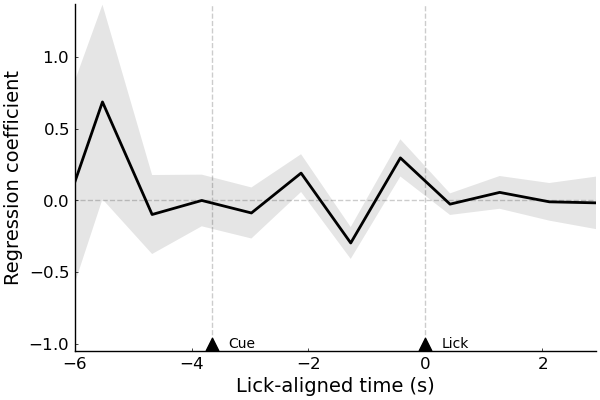

In [37]:
wintype, win = :rect, 1

yplot = smooth(y,      wintype, win)
eplot = smooth(stderr, wintype, win)

margin_y = 0.005

xlim = (-6, 4 + (7 - maximum(x))) # (minimum(x), maximum(x))
ylim = (minimum(yplot - eplot) - margin_y, maximum(yplot + eplot) + margin_y)

# Bidirectional dependency
pupdate = plot(x, yplot, ribbon=eplot,
    xlim=xlim,
    ylim=ylim,
    color=:black,
    fillalpha=0.1,
    linewidth=2,
    grid=:off,
    label="")

# Vertical lines at cue and lick time
vline!([-mean(lickbin), 0],
    color=:black,
    opacity=0.2,
    linestyle=:dash,
    label="")

# Horizontal line at x = 0
hline!([0],
    color=:black,
    opacity=0.2,
    linestyle=:dash,
    label="")

annotation_margin_x = 0.275
annotation_margin_y = (ylim[2] - ylim[1]) / 50

# Cue annotation
scatter!([-mean(lickbin)], [ylim[1] + annotation_margin_y],
    markershape = :utriangle,
    markersize = 9,
    markeralpha = 1,
    markercolor = :black,
    markerstrokewidth = 1,
    markerstrokealpha = 1,
    markerstrokecolor = :black,
    label="")
annotate!(-mean(lickbin) + annotation_margin_x, ylim[1] + annotation_margin_y,
    text("Cue", :black, :left, 10, fontfamily))

# Lick annotation
scatter!([0], [ylim[1] + annotation_margin_y],
    markershape = :utriangle,
    markersize = 9,
    markeralpha = 1,
    markercolor = :black,
    markerstrokewidth = 1,
    markerstrokealpha = 1,
    markerstrokecolor = :black,
    label="")
annotate!(annotation_margin_x, ylim[1] + annotation_margin_y,
    text("Lick", :black, :left, 10, fontfamily))

# Axis labels
xlabel!("Lick-aligned time (s)")
ylabel!("Regression coefficient")

xticks = [-6,-4,-2,0,2,4]
plot!(
    xticks=xticks,
    guidefont=font(guidefontsize, fontfamily),
    tickfont=font(tickfontsize, fontfamily),
)

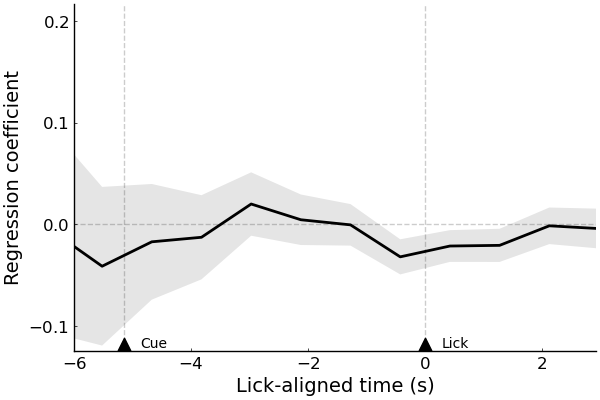

In [51]:
wintype, win = :rect, 3

yplot = smooth(y,      wintype, win)
eplot = smooth(stderr, wintype, win)

margin_y = 0.005

xlim = (-6, 4 + (7 - maximum(x))) # (minimum(x), maximum(x))
ylim = (minimum(yplot - eplot) - margin_y, maximum(yplot + eplot) + margin_y)

# Bidirectional dependency
pupdate_reverse = plot(x, yplot, ribbon=eplot,
    xlim=xlim,
    ylim=ylim,
    color=:black,
    fillalpha=0.1,
    linewidth=2,
    grid=:off,
    label="")

# Vertical lines at cue and lick time
vline!([-mean(lickbin), 0],
    color=:black,
    opacity=0.2,
    linestyle=:dash,
    label="")

# Horizontal line at x = 0
hline!([0],
    color=:black,
    opacity=0.2,
    linestyle=:dash,
    label="")

annotation_margin_x = 0.275
annotation_margin_y = (ylim[2] - ylim[1]) / 50

# Cue annotation
scatter!([-mean(lickbin)], [ylim[1] + annotation_margin_y],
    markershape = :utriangle,
    markersize = 9,
    markeralpha = 1,
    markercolor = :black,
    markerstrokewidth = 1,
    markerstrokealpha = 1,
    markerstrokecolor = :black,
    label="")
annotate!(-mean(lickbin) + annotation_margin_x, ylim[1] + annotation_margin_y,
    text("Cue", :black, :left, 10, fontfamily))

# Lick annotation
scatter!([0], [ylim[1] + annotation_margin_y],
    markershape = :utriangle,
    markersize = 9,
    markeralpha = 1,
    markercolor = :black,
    markerstrokewidth = 1,
    markerstrokealpha = 1,
    markerstrokecolor = :black,
    label="")
annotate!(annotation_margin_x, ylim[1] + annotation_margin_y,
    text("Lick", :black, :left, 10, fontfamily))

# Axis labels
xlabel!("Lick-aligned time (s)")
ylabel!("Regression coefficient")

xticks = [-6,-4,-2,0,2,4]
plot!(
    xticks=xticks,
    guidefont=font(guidefontsize, fontfamily),
    tickfont=font(tickfontsize, fontfamily),
)

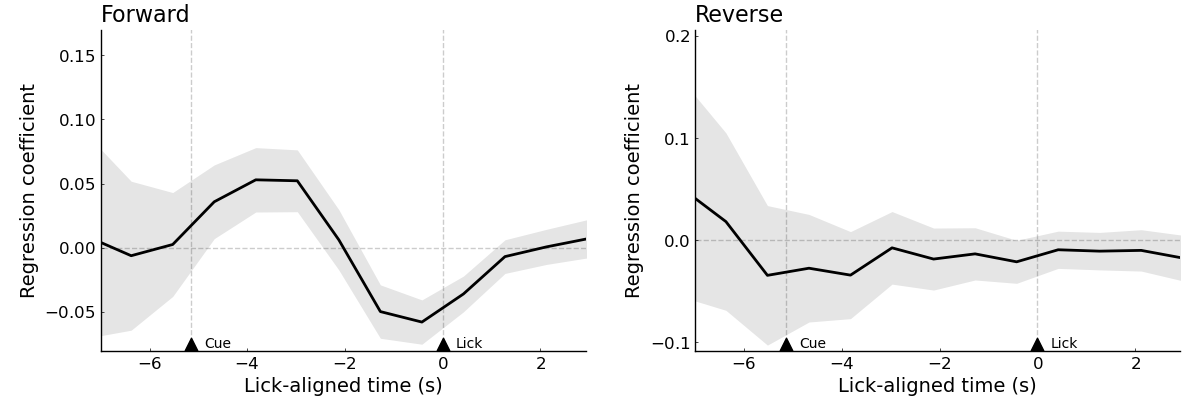

In [386]:
title!(pupdate, "Forward")
title!(pupdate_reverse, "Reverse")

plot(pupdate, pupdate_reverse,
    size=(1200,400),
    titleloc=:left,
    titlefont=font(16, :bold),
    layout=@layout([ a b ]);
    left_margin=5Plots.mm,
    right_margin=5Plots.mm,
    #top_margin=5Plots.mm,
    #bottom_margin=5Plots.mm
)

In [387]:
savefig("figs/discussion/forward_backward_last_20_percent.png")

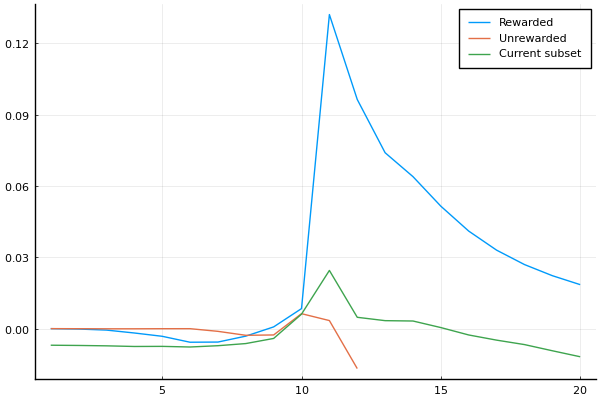

In [365]:
@pipe da_bins_all[trials_all.is_rewarded, :] |> Matrix |> mean(_, dims=1) |> vec |> plot(_, label="Rewarded")
@pipe da_bins_all[.!trials_all.is_rewarded, :] |> Matrix |> mean(_, dims=1) |> vec |> plot!(_, label="Unrewarded")
@pipe df[:,"x" .* string.(1:nbins)] |> Matrix |> mean(_, dims=1) |> vec |> plot!(_, label="Current subset")

In [71]:
savefig("figs/fig_empirical_plasticity.pdf")

### Plot both figs

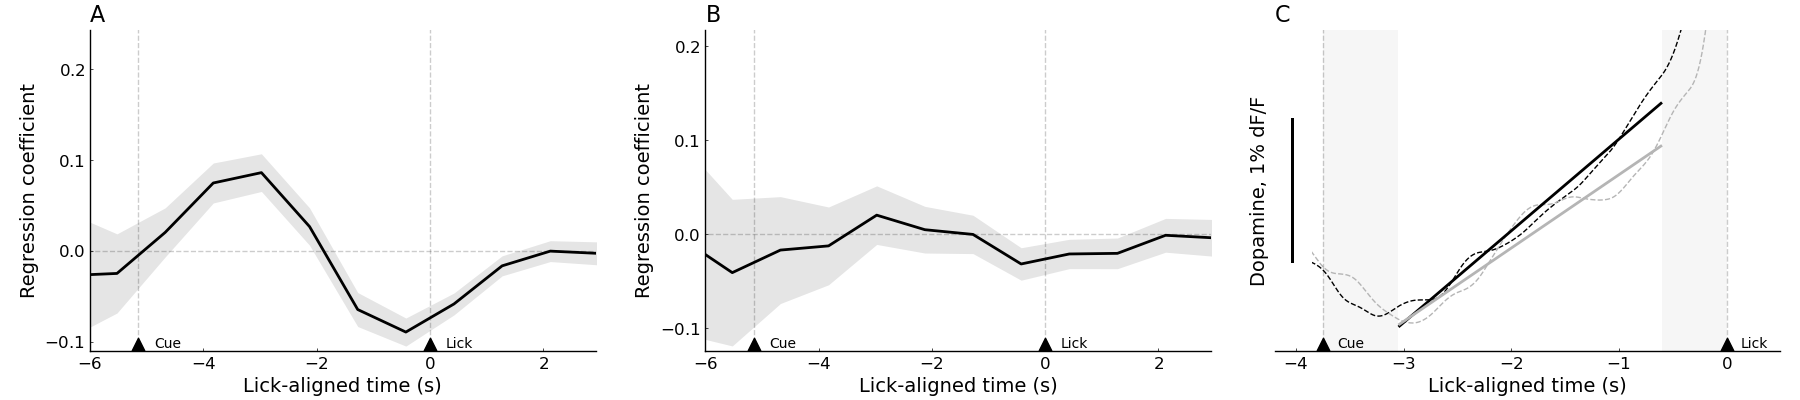

In [67]:
title!(pupdate, "A")
title!(pupdate_reverse, "B")
title!(pslope, "C")


plot(pupdate, pupdate_reverse, pslope,
    size=(1800,400),
    titleloc=:left,
    titlefont=font(16, :bold),
    layout=@layout([ a b c ]);
    left_margin=5Plots.mm,
    right_margin=5Plots.mm,
    #top_margin=5Plots.mm,
    #bottom_margin=5Plots.mm
)

In [68]:
savefig("figs/svg/fig_empirical.svg")

In [69]:
savefig("figs/fig_empirical.pdf")

### Statistical analysis

In [70]:
lickbin = [3.3, 7]
key = "trials without gaps"

coefs = zeros(nbins, length(sessions))
stderrs = zeros(nbins, length(sessions))

for (i, session) in enumerate(sessions)
    trials  = trials_all[findall(trials_all.session .== session), :]
    da_bins = da_bins_all[findall(trials_all.session .== session), :]
    
    lickbin_idx = findall(lickbin[1] .< trials.lick .- trials.cue .< lickbin[2])
    if length(lickbin_idx) == 0
        continue
    end
    if lickbin_idx[end] == nrow(trials)
        pop!(lickbin_idx)
    end
    
    indexes = lickbin_idx
    if key == "trials without gaps"
        indexes = lickbin_idx[trials.trial[lickbin_idx.+1] .- trials.trial[lickbin_idx] .== 1]
    elseif key == "all trials"
        indexes = lickbin_idx
    else
        @error "Unknown analysis key"
        break
    end

    Δda_slopes = trials.da_slope[2:end] - trials.da_slope[1:end-1]
    
    da = Matrix(da_bins[indexes,:])
    a  = Δda_slopes[indexes]
    
    ols    = fit(LinearModel, da, a)
    y      = replace(coef(ols),     NaN => 0)
    stderr = replace(stderror(ols), NaN => 0, Inf => 0)
    
    coefs[:,i] = y
    stderrs[:,i] = stderr
end

In [53]:
bins = get_bins(-mean(lickbin), 0, nbins, AbsBin(), AlignLick())
x = (bins[1:end-1] + bins[2:end]) / 2.0
;

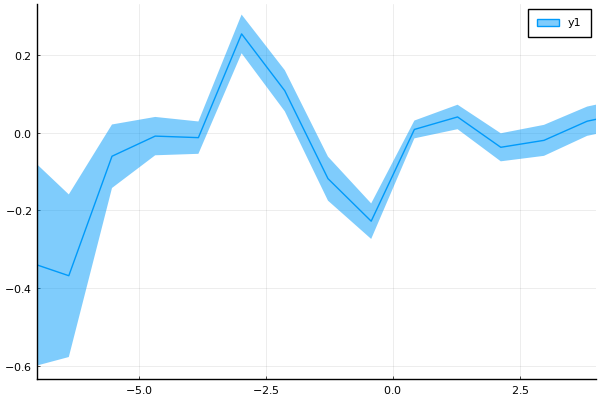

In [77]:
win = 1
plot(x, smooth(vec(mean(coefs, dims=2)), :rect, win),
    ribbon=(smooth(vec(mean(stderrs, dims=2) ./ sqrt(nbins)), :rect, win)),
    xlim=(-7, 4),
)

In [79]:
mean(lickbin)

5.15

In [80]:
(bins[7:8][1], bins[7:8][end])

(-3.4, -2.55)

In [56]:
(bins[6:6][1], bins[5:6][end])

(-5.1, -4.25)

In [43]:
coefs

20×9 Matrix{Float64}:
 -0.391922    -0.408268    -0.203367    …   0.076696     0.208984
  0.372601     0.203478     0.113246        0.0251407   -0.196774
  0.0202573    0.361896     0.136564       -0.0281701   -0.0384055
 -0.0661216   -0.219391    -0.0631618      -0.0538798    0.130599
  0.0389187   -0.0187181    0.0896009       0.0403226   -0.0843075
 -0.0408506    0.122507     0.0992045   …   0.00162549   0.0682663
  0.260506     0.227912     0.350173        0.388541     0.074577
  0.158558     0.301079     0.0835711       0.0471598    0.0441008
 -0.279985    -0.314877    -0.22154        -0.257764    -0.22408
 -0.155834    -0.33359     -0.277554       -0.206621     0.00768616
 -0.00560032   0.046829     0.0114513   …   0.00142586   0.0288339
  0.00219151  -0.0427397   -0.00618786      0.1292      -0.0569482
  0.0147884    0.0406156    0.0181894      -0.0578553    0.00293436
 -0.121145    -0.125194    -0.0642033      -0.117241    -0.00698957
  0.130454     0.11073      0.0296957      

One sample t-test
-----------------
Population details:
    parameter of interest:   Mean
    value under h_0:         0
    point estimate:          0.127949
    95% confidence interval: (-0.0538, 0.3097)

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.1432

Details:
    number of observations:   9
    t-statistic:              1.6232037266134778
    degrees of freedom:       8
    empirical standard error: 0.0788250091387893


In [47]:
pvalue(ttest)

0.00021545142981867178

In [52]:
ttest = OneSampleTTest(
    vec(mean(coefs[5:5,:], dims=1)),
    vec(mean(coefs[10:10,:], dims=1)),
)

One sample t-test
-----------------
Population details:
    parameter of interest:   Mean
    value under h_0:         0
    point estimate:          0.127949
    95% confidence interval: (-0.0538, 0.3097)

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.1432

Details:
    number of observations:   9
    t-statistic:              1.6232037266134778
    degrees of freedom:       8
    empirical standard error: 0.0788250091387893


In [81]:
ttest = OneSampleTTest(
    vec(mean(coefs[7:7,:], dims=1)),
    vec(mean(coefs[10:10,:], dims=1)),
)

One sample t-test
-----------------
Population details:
    parameter of interest:   Mean
    value under h_0:         0
    point estimate:          0.481507
    95% confidence interval: (0.3255, 0.6375)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-07

Details:
    number of observations:   89
    t-statistic:              6.133083476676759
    degrees of freedom:       88
    empirical standard error: 0.078509718352008


In [127]:
pvalue(ttest)

0.0043144673231485945

In [118]:
pvalue(ttest)

0.016624726936831213

### Bidirectional dependency (theory): final figure

In [31]:
matvals = read_matfile("fig_bidirectional_theory.mat")

T    = matvals["T"]    |> jvalue
t    = matvals["t"]    |> jvalue
Vh   = matvals["Vh"]   |> jvalue
dEta = matvals["dEta"] |> jvalue

# t is (1,N) for some reason
t = t[1,:];
ylim = (min(minimum(Vh), minimum(dEta)), max(maximum(Vh), maximum(dEta)))
;

In [14]:
twin_margins = Dict(
    :left_margin   => 5Plots.mm,
    :right_margin  => 19Plots.mm,
    :top_margin    => 5Plots.mm,
    :bottom_margin => 7Plots.mm
);

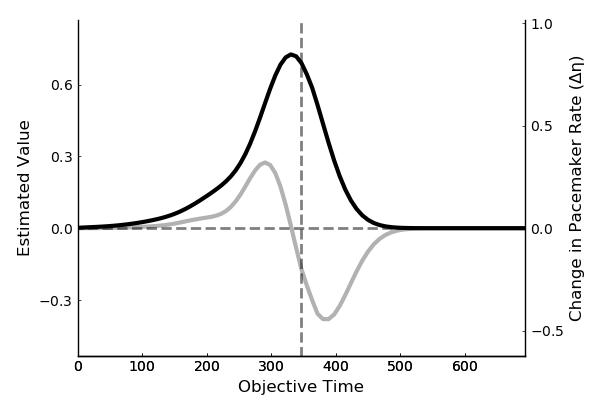

In [102]:
plot(t, Vh,
    color=:black,
    linewidth=3,
    grid=:off,
    label="",
    ylabel="Estimated Value",
    xlim=(0, 2*T),
    ylim=1.2.*ylim;
    twin_margins...)

p = twinx()
plot!(p, t[1:end-1], dEta,
    color=:black,
    opacity=.3,
    linewidth=3,
    grid=:off,
    label="",
    ylabel="Change in Pacemaker Rate (Δη)",
    xlim=(0, 2*T),
    ylim=1.4.*ylim;
    twin_margins...)

hline!(p, [0], color=:black, opacity=.5, linewidth=2, linestyle=:dash, label="")
vline!(p, [T], color=:black, opacity=.5, linewidth=2, linestyle=:dash, label="")
xlabel!(p, "Objective Time")

plot!(
    guidefont=font(12, fontfamily),
    tickfont=font(10, fontfamily),
)

In [103]:
savefig("figs/fig_bidirectional_theoretical.pdf")

### Relationship between RPE ramp slope and η: final figure

In [10]:
matvals = read_matfile("fig_rpe_eta.mat")
vals = Dict(k => jvalue(v) for (k,v) in matvals)

vals["t"]    = vals["t"][1,:]
vals["d"]    = vals["d"][1,:]
vals["dh"]   = vals["dh"][1,:]
vals["V"]    = vals["V"][1,:]
vals["Vh"]   = vals["Vh"][1,:]
vals["Vdot"] = vals["Vdot"][1,:]
;

In [34]:
pyplot();

In [11]:
using LaTeXStrings

In [20]:
guidefontsize = 12
tickfontsize = 10
legendfontsize = 9;

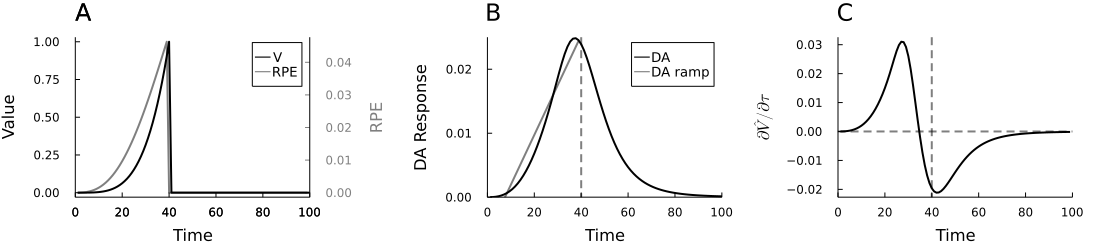

In [24]:
t = vals["t"]
dh = vals["dh"]

gray = colorant"rgba(0,0,0,0.5)"

# V and RPE
p1 = plot(vals["V"], ylabel="Value",
    xlim=(0, maximum(t)),
    #guidefont=font(guidefontsize, fontfamily),
    #tickfont=font(tickfontsize, fontfamily),
    color=:black,
    label="V";
    twin_margins...)

plot!(p1, [], [],
    color=gray,
    label="RPE",)

#vline!([vals["T"]], color=:black, opacity=.5, linestyle=:dash, label="")
xlabel!("Time")

p = twinx()


plot!(p, vals["d"], ylabel="RPE",
    xlim=(0, maximum(t)),
    #guidefont=font(guidefontsize, fontfamily, gray),
    #tickfont=font(tickfontsize, fontfamily, gray),
    yguidefontcolor=gray,
    yforeground_color_axis=gray,
    yforeground_color_border=gray,
    yforeground_color_guide=gray,
    yforeground_color_text=gray,
    color=gray,
    label="";
    twin_margins...)

title!("A")

# DA with uncertainty
p2 = plot(t[1:end-1]/vals["eta0"], dh, 
    xlim=(0, maximum(t)),
    yticks=([0, 0.01, 0.02]),
    #guidefont=font(guidefontsize, fontfamily),
    #tickfont=font(tickfontsize, fontfamily),
    color=:black,
    label="DA",
    left_margin=10Plots.mm,)
vline!([vals["T"]], color=:black, opacity=.5, linestyle=:dash, label="")
xlabel!("Time")
ylabel!("DA Response")

# Plot slope
idx = findall(t[1:end-1] ./ vals["eta0"] .<= vals["T"])
    
X = t[idx] ./ vals["eta0"]
Xfull = [ones(length(X)) X]
Y = dh[idx]
Yhat = Xfull * coef(fit(LinearModel, Xfull, Y))

plot!(X, Yhat,
    color=gray,
    ylim=(0, 0.025),
    label="DA ramp")
title!("B")

# Vdot
p3 = plot(vals["Vdot"],
    xlim=(0, maximum(t)),
    color=:black,
    #guidefont=font(guidefontsize, fontfamily),
    #tickfont=font(tickfontsize, fontfamily),
    label="",
    left_margin=10Plots.mm,
    right_margin=5Plots.mm,)
vline!([vals["T"]], color=:black, opacity=.5, linestyle=:dash, label="")
hline!([0], color=:black, opacity=.5, linestyle=:dash, label="")
xlabel!("Time")
ylabel!(L"\partial\hat{V}/\partial\tau") 
title!("C")


"""
# Plot relationship
p4 = plot(vals["etas"], vals["slopes"],
    color=:black,
    guidefont=font(12, fontfamily),
    tickfont=font(10, fontfamily),
    linewidth=2,
    grid=:off,
    #xlim=(minimum(vals["etas"]), maximum(vals["etas"])),
    yticks=([0.0005, 0.001, 0.0015]),
    label="")
xlabel!("Pacemaker rate (η)")
ylabel!("DA ramp slope")
title!("D")
"""

# Plot everything
#figure(figsize=(15,15))
plot(p1, p2, p3,
    size=(1100,250),
    linewidth=2,
    grid=:off,
    titleloc=:left,
    legendfontsize=legendfontsize,
    titlefont=font(16, :bold),
    layout=@layout [a b c])

In [42]:
savefig("figs/svg/fig_ramp_overview.svg")

In [25]:
savefig("figs/fig_ramp_overview_gr.pdf")

### Bidirectional dependency

In [16]:
binlen = TRIALLEN / nbins
function trim_signal_lamp_on(signal)
    if lickbin[2] < 7
        x = binlen * (LinRange(-nbins/2, nbins/2, nbins+1)[1:end-1] .+ 0.5)
        valid = x .< 7 - lickbin[2]
        return vcat(signal[valid], zeros(nbins - sum(valid)))
    end
end

function compute_avg_correlation(dict)
    sessions = collect(keys(dict))
    ks = keys(dict[sessions[1]])
    
    return Dict(
        k => mean([val[k] for (key, val) in dict]) |> trim_signal_lamp_on
        for k in ks
    )
end;

In [105]:
remove_baseline = false

corr_da_all = Dict()
corr_lick_all = Dict()
b_da_all = Dict()
b_lick_all = Dict()

da_all   = Dict("all trials" => zeros(0,20), "trials without gaps" => zeros(0,20))
a_da_all = Dict("all trials" => zeros(0), "trials without gaps" => zeros(0))

lickbin = [3.3, 7]

for session in sessions
    trials  = trials_all[findall(trials_all.session .== session), :]
    da_bins = da_bins_all[findall(trials_all.session .== session), :]
    
    lickbin_idx = findall(lickbin[1] .< trials.lick .- trials.cue .< lickbin[2])
    if length(lickbin_idx) == 0
        continue
    end
    if lickbin_idx[end] == nrow(trials)
        pop!(lickbin_idx)
    end
    
    # Compute indexes for different trial types
    indexes = Dict("all trials" => lickbin_idx)
    indexes["trials without gaps"] = lickbin_idx[trials.trial[lickbin_idx.+1] .- trials.trial[lickbin_idx] .== 1]
    #indexes["rewarded"]       = lickbin_idx[trials.is_rewarded[lickbin_idx]]
    #indexes["valid_rewarded"] = indexes["valid"][trials.is_rewarded[indexes["valid"]]] 

    Δda_slopes = trials.da_slope[2:end] .- trials.da_slope[1:end-1]

    licks = @. 1.0 / (trials.lick - trials.cue)
    Δlicks = licks[2:end] .- licks[1:end-1]

    a_da   = Dict(key => Δda_slopes[index] for (key, index) in indexes)
    a_lick = Dict(key => Δlicks[index]     for (key, index) in indexes)
    
    # Compute correlation
    da = da_bins .- (remove_baseline ? trials.da_baseline : 0)
    
    try        
        corr_da_all[session]   = get_correlations(da,  a_da,   indexes) 
        corr_lick_all[session] = get_correlations(da,  a_lick, indexes)
        b_da_all[session]      = get_contributions(da, a_da,   indexes)
        b_lick_all[session]    = get_contributions(da, a_lick, indexes)
        
        for (name, index) in indexes
            if !isempty(da[index,:])
                da_all[name] = vcat(da_all[name], Matrix(da[index,:]))
                a_da_all[name] = vcat(a_da_all[name], a_da[name])
            end
        end
    catch e
        println(session)
        println(e)
        println()
    end
end
;

b2_day15_op
LinearAlgebra.SingularException(1)

b2_day18_hybop
LinearAlgebra.SingularException(1)

h4_day15_hybop_100_250juice
LinearAlgebra.SingularException(1)



In [86]:
corr_da_avg   = compute_avg_correlation(corr_da_all)
corr_lick_avg = compute_avg_correlation(corr_lick_all)

b_da_avg   = compute_avg_correlation(b_da_all)
b_lick_avg = compute_avg_correlation(b_lick_all);

In [ ]:
plot_contribution(b_da_all,
    win=5,
    title="",
    ylabel="Contribution to update term (AU)",
    show_grid_label=false
)

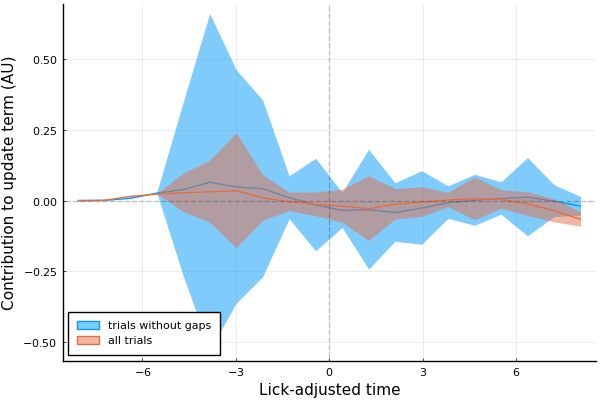

In [79]:
plot_contribution(b_da_all,
    win=5,
    title="",
    ylabel="Contribution to update term (AU)",
    show_grid_label=false
)

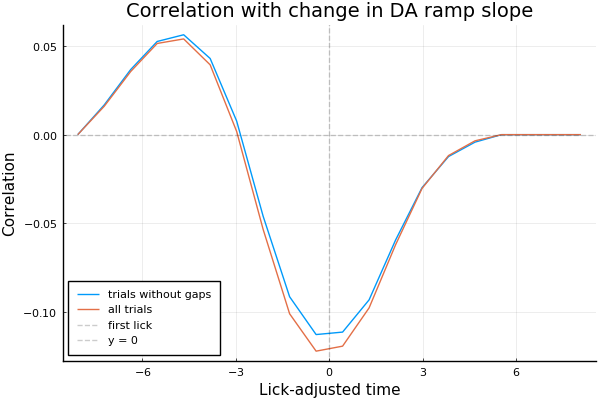

In [52]:
plot_dict(corr_da_avg,
    win=5,
    title="Correlation with change in DA ramp slope",
    ylabel="Correlation"
)

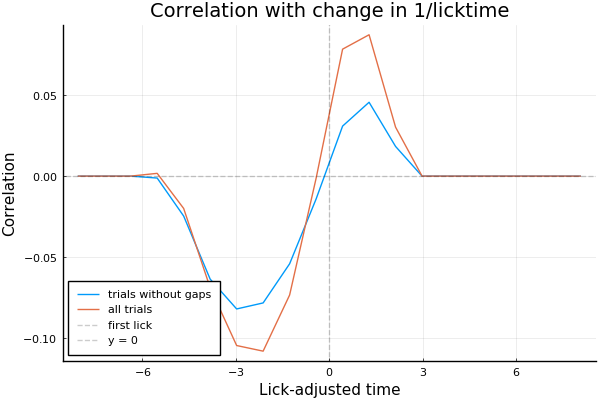

In [53]:
plot_dict(corr_lick_avg,
    win=2,
    title="Correlation with change in 1/licktime",
    ylabel="Correlation"
)

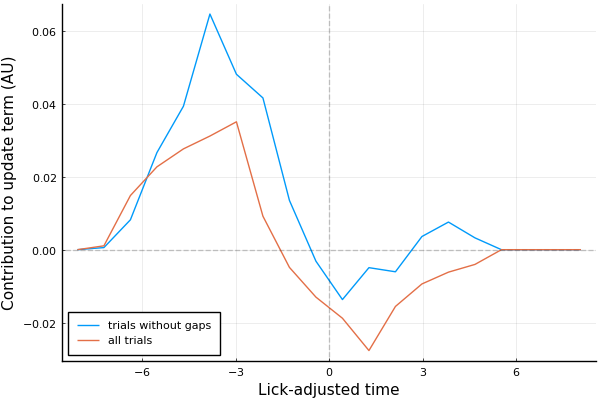

In [58]:
plot_dict(b_da_avg,
    win=5,
    title="",
    ylabel="Contribution to update term (AU)",
    show_grid_label=false
)

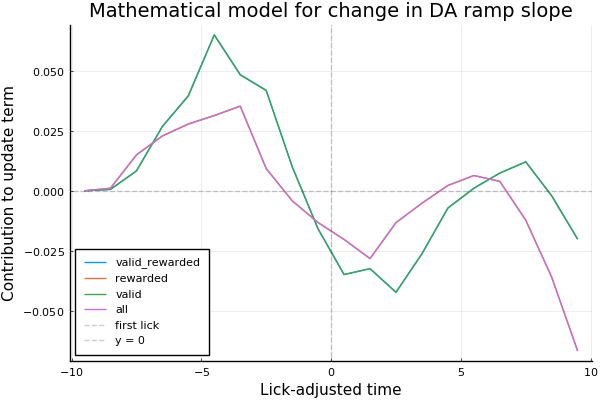

In [33]:
plot_dict(b_da_avg,
    win=5,
    title="Mathematical model for change in DA ramp slope",
    ylabel="Contribution to update term"
)

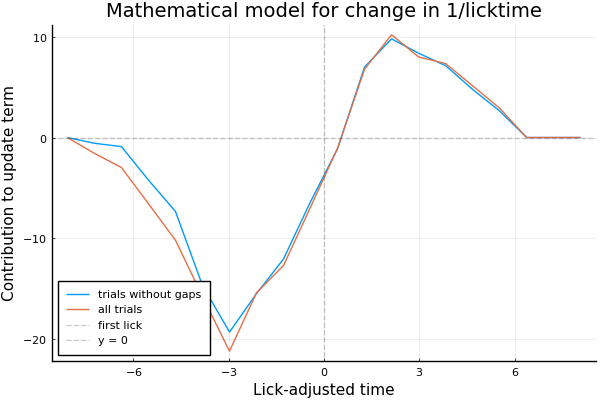

In [57]:
plot_dict(b_lick_avg,
    win=6,
    title="Mathematical model for change in 1/licktime",
    ylabel="Contribution to update term"
)

In [59]:
binlim = [4.5, 5];

In [60]:
x = abs_binlen .* (LinRange(-nbins/2, nbins/2, nbins+1)[1:end-1] .+ 0.5);

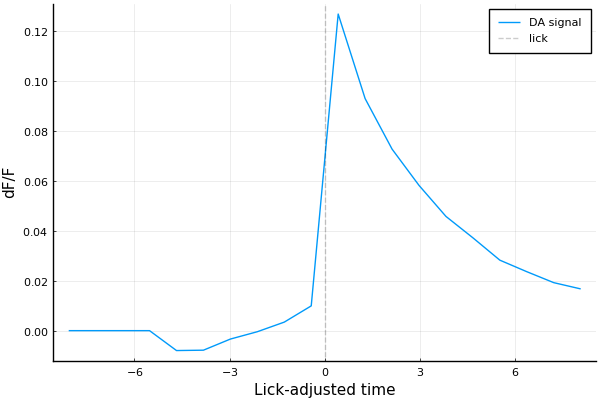

In [71]:
dfidx = (binlim[1] .< trials_all.lick .- trials_all.cue .< binlim[2])
df = da_bins_all[dfidx, :]
plot(x, getfirstrow(mapcols(c -> mean(c), df)), label="DA signal")
#title!("n = $(nrow(df)), slope = $(mean(trials_all.da_slope[dfidx]))")

dfidx .&= trials_all.is_rewarded
df = da_bins_all[dfidx, :]
#plot!(x, getfirstrow(mapcols(c -> mean(c), df)), label="rewarded")
vline!([0], color="black", opacity=0.2, linestyle=:dash, label="lick")

xlabel!("Lick-adjusted time")
ylabel!("dF/F")

In [72]:
savefig("tp_photometry.pdf")

In [39]:
dfidx = findall((binlim[1] .< trials_all.lick .- trials_all.cue .< binlim[2]))[1:end-1]
Δ = trials_all.da_slope[dfidx.+1] .- trials_all.da_slope[dfidx];

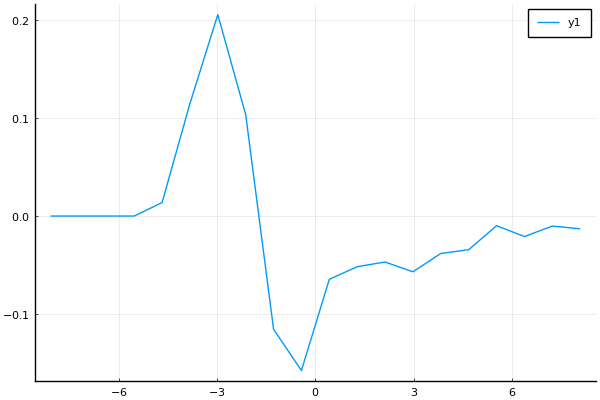

In [40]:
row = getfirstrow(mapcols(c -> mean(c), da_bins_all[dfidx,:]));
c = mapcols(c -> cor(c, Δ), da_bins_all[dfidx,:]) |> getfirstrow
replace!(c, NaN => 0)
plot(x, c)

### Old code

In [47]:
remove_baseline = false

corr                = zeros(length(trials_all), nbins)
corr_valid          = zeros(length(trials_all), nbins)
corr_rewarded       = zeros(length(trials_all), nbins)
corr_valid_rewarded = zeros(length(trials_all), nbins)

for mouse in 1:length(trials_all)
    trials = trials_all[mouse]
    
    idx                = 1:length(trials)-1
    idx_valid          = findall(i -> trials[i+1].index == trials[i].index+1, idx)
    idx_rewarded       = findall(i -> trials[i].is_rewarded, idx)
    idx_valid_rewarded = idx_valid[findall(i -> trials[i].is_rewarded, idx_valid)]

    da_slopes = map(t -> t.da_slope, trials)
    Δda_slopes = da_slopes[2:end] .- da_slopes[1:end-1]
    
    licks = map(t -> 1.0 / (t.lick - buffer_pre_lick - t.cue - buffer_post_cue), trials)
    Δlicks = licks[2:end] .- licks[1:end-1]

    slope                = Δda_slopes[idx]
    slope_valid          = Δda_slopes[idx_valid]
    slope_rewarded       = Δda_slopes[idx_rewarded]
    slope_valid_rewarded = Δda_slopes[idx_valid_rewarded]

    for bin in 1:nbins
        corr[mouse,bin] = cor(
            map(t -> t.da_bins[bin] - (remove_baseline ? t.da_baseline : 0), trials[idx]),
            slope)

        corr_valid[mouse,bin] = cor(
            map(t -> t.da_bins[bin] - (remove_baseline ? t.da_baseline : 0), trials[idx_valid]),
            slope_valid)

        corr_rewarded[mouse,bin] = cor(
            map(t -> t.da_bins[bin] - (remove_baseline ? t.da_baseline : 0), trials[idx_rewarded]),
            slope_rewarded)

        corr_valid_rewarded[mouse,bin] = cor(
            map(t -> t.da_bins[bin] - (remove_baseline ? t.da_baseline : 0), trials[idx_valid_rewarded]),
            slope_valid_rewarded)
    end
end

replace!(corr, NaN => 0)
replace!(corr_valid, NaN => 0)
replace!(corr_rewarded, NaN => 0)
replace!(corr_valid_rewarded, NaN => 0)
;

In [48]:
avg(c) = @pipe c |> mean(_, dims=1) |> dropdims(_, dims=1)

corr                = avg(corr)
corr_valid          = avg(corr_valid)
corr_rewarded       = avg(corr_rewarded)
corr_valid_rewarded = avg(corr_valid_rewarded)
;

In [19]:
x = abs_binlen .* (LinRange(-nbins/2, nbins/2, nbins+1)[1:end-1] .+ 0.5);

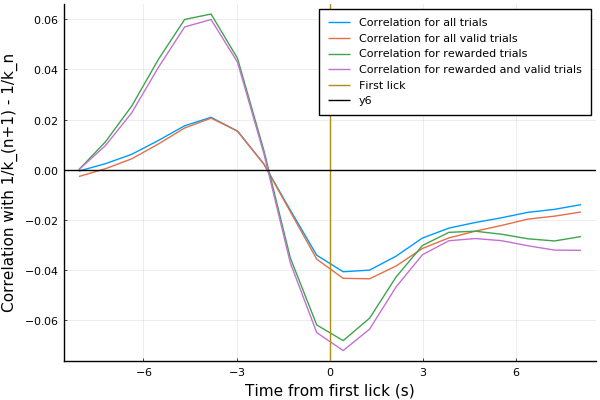

In [50]:
win = 4

plot(x,  smooth(corr, :rect, win),                label="Correlation for all trials", legend=:topright)
plot!(x, smooth(corr_valid, :rect, win),          label="Correlation for all valid trials")
plot!(x, smooth(corr_rewarded, :rect, win),       label="Correlation for rewarded trials")
plot!(x, smooth(corr_valid_rewarded, :rect, win), label="Correlation for rewarded and valid trials")

xlabel!("Time from first lick (s)")
ylabel!("Correlation with 1/k_(n+1) - 1/k_n")
vline!([0], label="First lick")
hline!([0], color="black")

### Model

In [14]:
df = nothing
D = zeros(nbins, sum(map(length, trials_all)))
d_idx = 0

for mouse in 1:length(trials_all)
    trials = trials_all[mouse]
    
    da_slopes = map(t -> t.da_slope, trials)
    da_maxs   = map(t -> t.da_max, trials)
    da_licks  = map(t -> t.lick - buffer_pre_lick - t.cue - buffer_post_cue, trials)
    
    indexes =   map(t -> t.index, trials)
    fname   =   map(t -> t.fname, trials)
    rewards =   map(t -> t.is_rewarded, trials)
    
    df_trial = DataFrame(
        filename = fname,
        trial = indexes,
        da_slope = da_slopes,
        da_max = da_maxs,
        lick = da_licks,
        rewarded = rewards
    )
    if df == nothing
        df = df_trial
    else 
        append!(df, df_trial)
    end
    
    D[:,d_idx+1:d_idx+length(trials)] = hcat(map(t -> t.da_bins, trials)...)
    d_idx += length(trials)
end
;

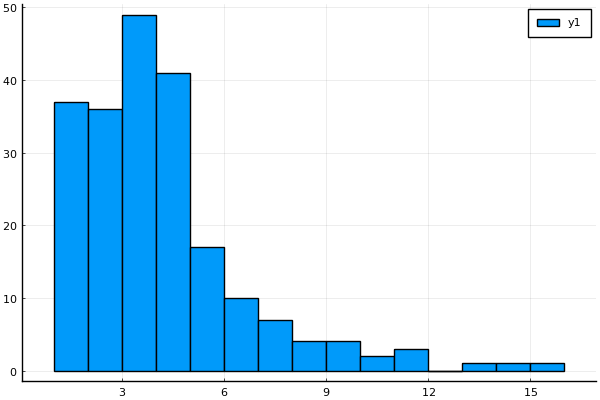

In [55]:
histogram(map(t -> floor(Int, t.lick - t.cue), trials_all[1]))

In [64]:
licktimes = map(_ -> zeros(Int, 0), zeros(17))
for trial in trials_all[1]
    push!(licktimes[floor(Int, trial.lick - trial.cue)], trial.index)
end

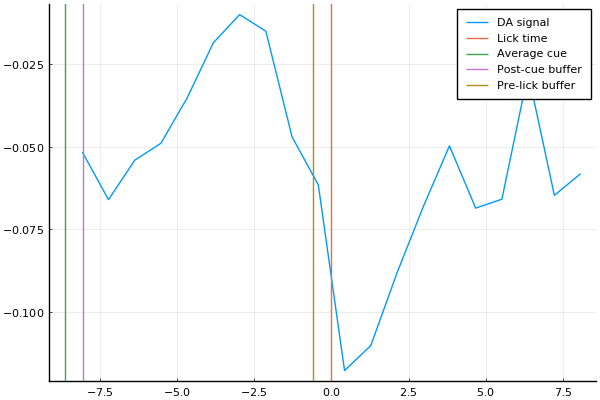

In [116]:
index = 8

plot(x, dropdims(mean(D[:,indexin(licktimes[index], df[!,:trial])], dims=2), dims=2), label="DA signal")
vline!([0], label="Lick time")

vline!([-(mean(df[indexin(licktimes[index], df[!,:trial]), :lick]) + buffer_post_cue + buffer_pre_lick)], label="Average cue")
vline!([-(mean(df[indexin(licktimes[index], df[!,:trial]), :lick]) + buffer_post_cue)], label="Post-cue buffer")
vline!([-buffer_pre_lick ], label="Pre-lick buffer")

In [ ]:
pyplot();

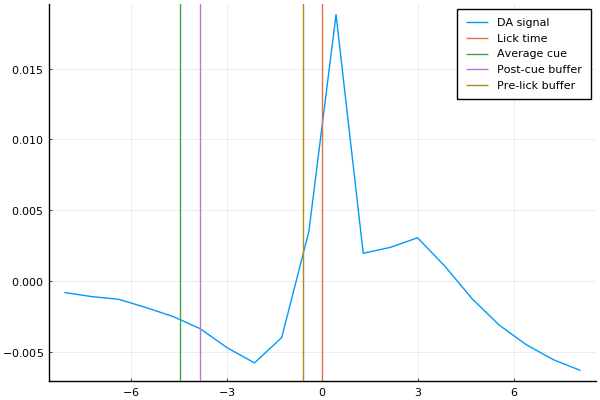

In [44]:
plot(x, dropdims(mean(D, dims=2), dims=2), label="DA signal")
vline!([0], label="Lick time")

vline!([-(mean(df[!,:lick]) + buffer_post_cue + buffer_pre_lick)], label="Average cue")
vline!([-(mean(df[!,:lick]) + buffer_post_cue)], label="Post-cue buffer")
vline!([-buffer_pre_lick ], label="Pre-lick buffer")

In [45]:
savefig("da_avg.png")

In [195]:
XLSX.writetable("hamilos_da_bins.xlsx", collect(eachrow(D)), map(i -> "bin $i", 1:nbins))

In [192]:
import XLSX
XLSX.writetable("hamilos_trials.xlsx", collect(DataFrames.eachcol(df)), DataFrames.names(df))

In [191]:
df[]

44382×6 DataFrame
   Row │ filename         trial  da_slope     da_max       lick       rewarded ⋯
       │ String           Int64  Float64      Float64      Float64    Bool     ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │ b1_day13op           1   0.0412392   -0.0781915    2.71657       true ⋯
     2 │ b1_day13op           2   0.0311649    0.034204     1.93546      false
     3 │ b1_day13op           3   0.00254489   0.064189     3.87297      false
     4 │ b1_day13op           4   0.0568538    0.10765      2.5564        true
     5 │ b1_day13op           5  -0.00303197  -0.0917279    4.12695      false ⋯
     6 │ b1_day13op           6  -0.0121742    0.0350474    1.58185      false
     7 │ b1_day13op           7  -0.00317682   0.0408855    3.59569       true
     8 │ b1_day13op           8   0.019703    -0.0675289    2.82295       true
     9 │ b1_day13op           9  -0.00148118   0.0313347    1.92294      false ⋯
    10 │ b1_day13op          10   0.0168262    0.0438041    6.28062      false
    11 │ b1_day13op          11   0.0272875    0.131489     3.30405       true
   ⋮   │        ⋮           ⋮         ⋮            ⋮           ⋮         ⋮     ⋱
 44373 │ h6_day15_hybop0    879  -1.94048e-6   0.0313085    0.7074       false
 44374 │ h6_day15_hybop0    880  -0.00257647  -0.0893721   13.3339       false ⋯
 44375 │ h6_day15_hybop0    881   3.99548e-6  -0.0973195    0.498425     false
 44376 │ h6_day15_hybop0    882   9.29768e-6  -0.00325054   4.37715       true
 44377 │ h6_day15_hybop0    883   1.02813e-7   0.0517764    8.76275      false
 44378 │ h6_day15_hybop0    884  -6.76334e-7  -0.18041     10.6877       false ⋯
 44379 │ h6_day15_hybop0    886  -5.8221e-7    0.024435     5.63735       true
 44380 │ h6_day15_hybop0    887   1.06983e-6  -0.0106677    1.92142      false
 44381 │ h6_day15_hybop0    888  -4.04569e-7   0.0367545    7.9367       false
 44382 │ h6_day15_hybop0    889   1.29794e-6   0.0755492    2.7447        true ⋯
                                                             44361 rows omitted

In [171]:
remove_baseline = false

D                = zeros(0, nbins)
D_valid          = zeros(0, nbins)
D_rewarded       = zeros(0, nbins)
D_valid_rewarded = zeros(0, nbins)

a_da = zeros(0)
a_da_valid = zeros(0)
a_da_rewarded = zeros(0)
a_da_valid_rewarded = zeros(0)

a_lick = zeros(0)
a_lick_valid = zeros(0)
a_lick_rewarded = zeros(0)
a_lick_valid_rewarded = zeros(0)

for mouse in 1:length(trials_all)
    trials = trials_all[mouse]
    
    idx                = 1:length(trials)-1
    idx_valid          = idx[findall(i -> trials[i+1].index == trials[i].index+1, idx)]
    idx_rewarded       = idx[findall(i -> trials[i].is_rewarded, idx)]
    idx_valid_rewarded = idx_valid[findall(i -> trials[i].is_rewarded, idx_valid)]

    da_slopes = map(t -> t.da_slope, trials)
    Δda_slopes = da_slopes[2:end] .- da_slopes[1:end-1]

    licks = map(t -> 1.0 / (t.lick - buffer_pre_lick - t.cue - buffer_post_cue), trials)
    Δlicks = licks[2:end] .- licks[1:end-1]

    a_da                  = vcat(a_da, Δda_slopes[idx])
    a_da_valid            = vcat(a_da_valid, Δda_slopes[idx_valid])
    a_da_rewarded         = vcat(a_da_rewarded, Δda_slopes[idx_rewarded])
    a_da_valid_rewarded   = vcat(a_da_valid_rewarded, Δda_slopes[idx_valid_rewarded])

    a_lick                = vcat(a_lick, Δlicks[idx])
    a_lick_valid          = vcat(a_lick_valid, Δlicks[idx_valid])
    a_lick_rewarded       = vcat(a_lick_rewarded, Δlicks[idx_rewarded])
    a_lick_valid_rewarded = vcat(a_lick_valid_rewarded, Δlicks[idx_valid_rewarded])
    
    D                = vcat(D,                hcat(map(t -> t.da_bins, trials[idx])...)')
    D_valid          = vcat(D_valid,          hcat(map(t -> t.da_bins, trials[idx_valid])...)')
    D_rewarded       = vcat(D_rewarded,       hcat(map(t -> t.da_bins, trials[idx_rewarded])...)')
    D_valid_rewarded = vcat(D_valid_rewarded, hcat(map(t -> t.da_bins, trials[idx_valid_rewarded])...)')
end
;

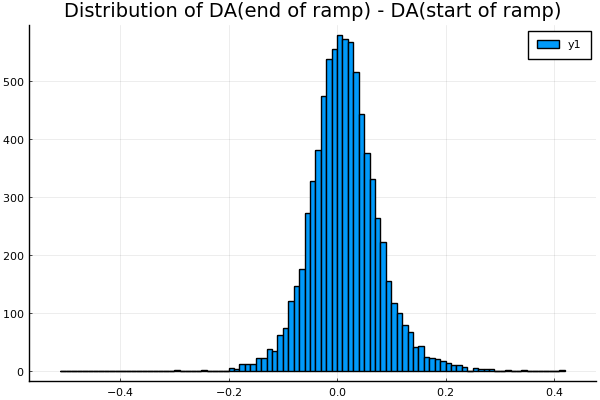

In [62]:
histogram(vcat([[trs[i].da_max for i in 1:length(trs)-1 if trs[i].is_rewarded] for trs in trials_all]...))
title!("Distribution of DA(end of ramp) - DA(start of ramp)")

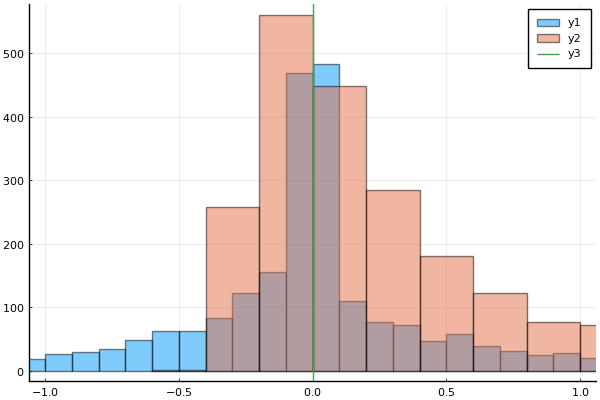

In [360]:
histogram(a_da_valid_rewarded, alpha=0.5, xlim=[-1, 1])
histogram!(a_lick_valid_rewarded, alpha=0.5, xlim=[-1, 1])
vline!([0])

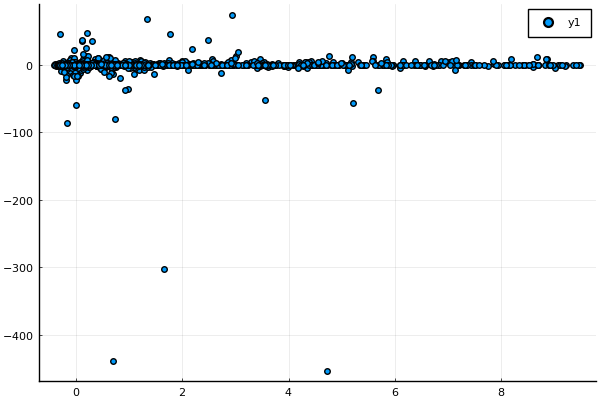

In [353]:
scatter(
    a_lick_valid_rewarded,
    a_da_valid_rewarded
)

In [172]:
b_da                  = D \ a_da
b_da_valid            = D_valid \ a_da_valid
b_da_rewarded         = D_rewarded \ a_da_rewarded
b_da_valid_rewarded   = D_valid_rewarded \ a_da_valid_rewarded

b_lick                = D \ a_lick
b_lick_valid          = D_valid \ a_lick_valid
b_lick_rewarded       = D_rewarded \ a_lick_rewarded
b_lick_valid_rewarded = D_valid_rewarded \ a_lick_valid_rewarded
;

In [54]:
x = abs_binlen .* (LinRange(-nbins/2, nbins/2, nbins+1)[1:end-1] .+ 0.5);

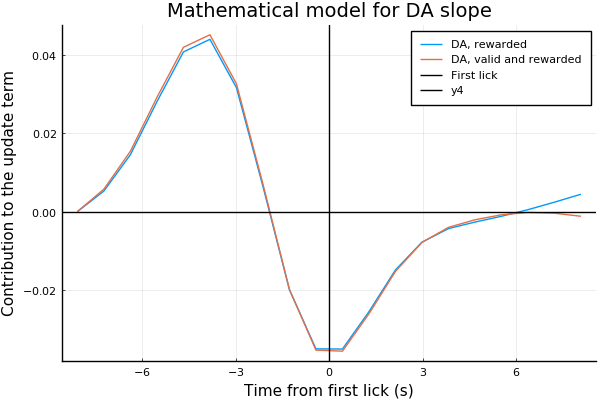

In [173]:
win = 8

#plot(x, smooth(b_da, :hamming, win), label="DA, all")
#plot!(x, smooth(b_da_valid, :hamming, win), label="DA, valid")
plot(x, smooth(b_da_rewarded, :hamming, win), label="DA, rewarded")
plot!(x, smooth(b_da_valid_rewarded, :hamming, win), label="DA, valid and rewarded")
vline!([0], color="black", label="First lick")
hline!([0], color="black")
xlabel!("Time from first lick (s)")
ylabel!("Contribution to the update term")
title!("Mathematical model for DA slope")

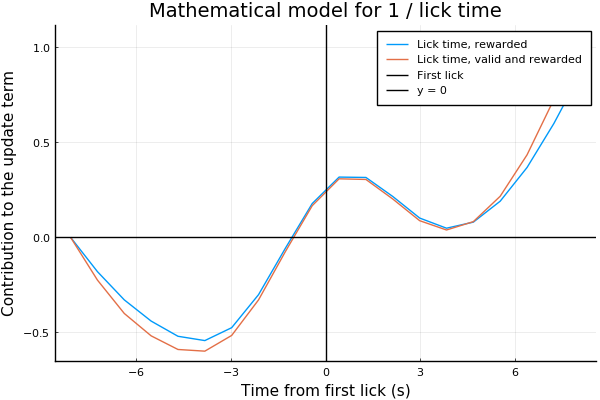

In [174]:
win = 8

#plot(x, smooth(b_lick, :hamming, win), label="Lick time, all")
#plot(x, smooth(b_lick_valid, :hamming, win), label="Lick time, valid")
plot(x, smooth(b_lick_rewarded, :hamming, win), label="Lick time, rewarded")
plot!(x, smooth(b_lick_valid_rewarded, :hamming, win), label="Lick time, valid and rewarded")
vline!([0], color="black", label="First lick")
hline!([0], color="black", label="y = 0")
xlabel!("Time from first lick (s)")
ylabel!("Contribution to the update term")
title!("Mathematical model for 1 / lick time")

In [103]:
#savefig("eda_hamilos_lick.png")

In [ ]:
write_matfile(filename; D=D, D_valid=D_valid, D_rewarded=D_rewarded, D_valid_rewarded=D_valid_rewarded)

### Negative DA slope?

In [ ]:
trials = trials_all[1]

idx                = 1:length(trials)-1
idx_valid          = findall(i -> trials[i+1].index == trials[i].index+1, idx)
idx_rewarded       = findall(i -> trials[i].is_rewarded, idx)
idx_valid_rewarded = idx_valid[findall(i -> trials[i].is_rewarded, idx_valid)]

da_slopes = map(t -> t.da_slope, trials)
Δda_slopes = da_slopes[2:end] .- da_slopes[1:end-1]

licks = map(t -> 1.0 / (t.lick - t.cue), trials)
Δlicks = licks[2:end] .- licks[1:end-1]

y                = Δda_slopes[idx]
y_valid          = Δda_slopes[idx_valid]
y_rewarded       = Δda_slopes[idx_rewarded]
y_valid_rewarded = Δda_slopes[idx_valid_rewarded]

x                = Δlicks[idx]
x_valid          = Δlicks[idx_valid]
x_rewarded       = Δlicks[idx_rewarded]
x_valid_rewarded = Δlicks[idx_valid_rewarded]

scatter(x, y)

In [ ]:
remove_baseline = false

da_levels                = map(_ -> Float64[], 1:nbins)
da_levels_valid          = map(_ -> Float64[], 1:nbins)
da_levels_rewarded       = map(_ -> Float64[], 1:nbins)
da_levels_valid_rewarded = map(_ -> Float64[], 1:nbins)

da_slopes                = Float64[]
da_slopes_valid          = Float64[]
da_slopes_rewarded       = Float64[]
da_slopes_valid_rewarded = Float64[]

for mouse in 1:length(trials_all)
    trials = trials_all[mouse]

    idx                = 1:length(trials)-1
    idx_valid          = findall(i -> trials[i+1].index == trials[i].index+1, idx)
    idx_rewarded       = findall(i -> trials[i].is_rewarded, idx)
    idx_valid_rewarded = idx_valid[findall(i -> trials[i].is_rewarded, idx_valid)]
    
    all_slopes = map(t -> t.da_slope, trials)
    Δda_slopes = all_slopes[2:end] .- all_slopes[1:end-1]
    
    # licks = map(t -> 1.0 / (t.lick - t.cue), trials)
    # Δlicks = licks[2:end] .- licks[1:end-1]

    slope                = Δda_slopes[idx]
    slope_valid          = Δda_slopes[idx_valid]
    slope_rewarded       = Δda_slopes[idx_rewarded]
    slope_valid_rewarded = Δda_slopes[idx_valid_rewarded]
    
    da_slopes                = vcat(da_slopes, slope)
    da_slopes_valid          = vcat(da_slopes_valid, slope_valid)
    da_slopes_rewarded       = vcat(da_slopes_rewarded, slope_rewarded)
    da_slopes_valid_rewarded = vcat(da_slopes_valid_rewarded, slope_valid_rewarded)
    
    da_act = map(t -> t.da_bins .- (remove_baseline ? t.da_baseline : 0), trials)
    
    for bin in 1:nbins
        da_levels[bin] = vcat(
            da_levels[bin], 
            map(da -> da[bin], da_act[idx])
        )
        
        da_levels_valid[bin] = vcat(
            da_levels_valid[bin], 
            map(da -> da[bin], da_act[idx_valid])
        )
        
        da_levels_rewarded[bin] = vcat(
            da_levels_rewarded[bin], 
            map(da -> da[bin], da_act[idx_rewarded])
        )
        
        da_levels_valid_rewarded[bin] = vcat(
            da_levels_valid_rewarded[bin], 
            map(da -> da[bin], da_act[idx_valid_rewarded])
        )
    end
end

corr                = map(da -> cor(da, da_slopes),                da_levels)
corr_valid          = map(da -> cor(da, da_slopes_valid),          da_levels_valid)
corr_rewarded       = map(da -> cor(da, da_slopes_rewarded),       da_levels_rewarded)
corr_valid_rewarded = map(da -> cor(da, da_slopes_valid_rewarded), da_levels_valid_rewarded)

replace!(corr, NaN => 0)
replace!(corr_valid, NaN => 0)
replace!(corr_rewarded, NaN => 0)
replace!(corr_valid_rewarded, NaN => 0)
;

In [ ]:
x = abs_binlen .* (LinRange(-nbins/2, nbins/2, nbins+1)[1:end-1] .+ 0.5);

In [ ]:
plot(x,  corr,                label="Correlation for all trials", legend=:topright)
plot!(x, corr_valid,          label="Correlation for all valid trials")
plot!(x, corr_rewarded,       label="Correlation for rewarded trials")
plot!(x, corr_valid_rewarded, label="Correlation for rewarded and valid trials")

xlabel!("Time from first lick")
ylabel!("Correlation with  DA slope on the next trial")
vline!([0], label="First lick")
hline!([0], color="black")

In [ ]:
win = 3

plot(x,  smooth(corr, :rect, win),                label="Correlation for all trials", legend=:topright)
plot!(x, smooth(corr_valid, :rect, win),          label="Correlation for all valid trials")
plot!(x, smooth(corr_rewarded, :rect, win),       label="Correlation for rewarded trials")
plot!(x, smooth(corr_valid_rewarded, :rect, win), label="Correlation for rewarded and valid trials")

xlabel!("Time from first lick")
ylabel!("Correlation with  DA slope on the next trial")
vline!([0], label="First lick")
hline!([0], color="black")